<a href="https://colab.research.google.com/github/PolMix/nems_ai/blob/main/Classic%20ML/Classic_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lib import

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  
from matplotlib import cm

# Удобства
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Модели
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import clone

!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetRegressor

from xgboost import XGBRegressor

!pip3 install optuna
import optuna

# Метрики качества
from time import time

from sklearn.metrics import r2_score, mean_squared_error

# Обработка датасета, кроссвалидация
from sklearn.model_selection import train_test_split, KFold, cross_validate

# Нормировка датасета
from sklearn.preprocessing import RobustScaler, StandardScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Скачивание предобработанного датасета

Загружаем датасет с GitHub:

In [ ]:
import zipfile
import os

!wget --no-check-certificate \
    "https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip" \
    -O "/tmp/data.zip"


zip_ref = zipfile.ZipFile('/tmp/data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2023-05-13 11:35:06--  https://github.com/PolMix/nems_ai/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main [following]
--2023-05-13 11:35:06--  https://codeload.github.com/PolMix/nems_ai/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip           [      <=>           ]  13.59M  5.85MB/s    in 2.3s    

2023-05-13 11:35:09 (5.85 MB/s) - ‘/tmp/data.zip’ saved [14249699]



In [ ]:
%cd '/tmp/nems_ai-main/Data Processed'
filename = 'Dataset_Processed.csv'
df = pd.read_csv(filename)
df = df.drop(columns='Unnamed: 0')
df.head()

/tmp/nems_ai-main/Data Processed


,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz),M1 Quality factor,...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
0,10.666186,759.454713,192.911166,46.497924,19.089801,465.822644,28.323179,9.003567e+08,6.415102e+07,1.336133e+04,...,2.909667e+08,1.143351e+04,2.560363e-15,6.037978e-22,3.409430e-12,3.964520e+08,1.013999e+04,8.780197e-16,3.181145e-22,4.959458e-12
1,105.195552,890.696186,209.252268,37.407275,3.716553,314.636835,30.305477,5.090849e+08,2.569354e+06,7.177442e+06,...,8.224139e+06,5.740452e+06,3.281744e-14,8.720428e-28,1.367533e-11,1.152226e+07,5.003229e+06,3.291971e-14,1.406151e-27,1.583936e-11
2,10.310316,221.113532,195.903798,37.079461,0.027053,251.500693,26.675832,6.351363e+08,3.353110e+07,2.675673e+06,...,1.267642e+08,1.891218e+06,7.206070e-16,6.788349e-28,2.254001e-12,1.923697e+08,1.709827e+06,7.147747e-16,1.130223e-27,2.477637e-12
3,18.683573,282.662136,207.614117,18.750307,0.496423,172.245797,2.647445,0.000000e+00,1.049078e+07,8.772643e+06,...,4.475571e+07,8.332783e+06,1.623836e-15,6.849769e-28,2.943955e-12,7.057576e+07,8.000998e+06,1.616668e-15,1.119973e-27,3.081568e-12
4,121.747842,991.550766,102.506945,29.297485,2.037235,415.471216,18.419812,8.374213e+08,2.649739e+06,7.314592e+06,...,8.269131e+06,6.082613e+06,2.259615e-14,2.331664e-28,2.518650e-11,1.138111e+07,5.405428e+06,2.267905e-14,3.624442e-28,2.982471e-11


Скачивание файла с тестовым устройством из края распределений параметров:

In [ ]:
filename_test = 'Data_Processed_Boundary_Test.csv'
df_test = pd.read_csv(filename_test)
df_test = df_test.drop(columns='Unnamed: 0')
df_test.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 Noise (kg^2/s^3),M3 TED (W),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 Noise (kg^2/s^3),M4 TED (W)
0,821.402113,897.519396,200.0,36.102266,2.248089,924.978487,39.775523,169003.789805,53781.219971,2.581146e-13,...,5.089901e+05,53640.722509,2.582148e-13,4.490996e-28,1.441984e-11,6.809541e+05,53577.353352,2.583005e-13,6.009473e-28,2.286573e-11
1,187.634453,482.065578,150.0,19.450374,161.773060,911.580688,10.599196,512665.917301,27829.840781,2.167964e-14,...,1.616819e+06,25729.966624,2.199621e-14,3.120787e-25,1.475224e-11,2.243525e+06,24670.596346,2.212375e-14,4.356675e-25,1.758884e-11
2,638.204045,242.947138,100.0,24.144951,3.181935,455.886263,15.074379,221111.869936,14575.916394,2.871363e-14,...,6.636297e+05,14574.507206,2.871555e-14,5.640215e-28,7.054148e-13,8.851790e+05,14573.764249,2.871377e-14,7.522689e-28,1.155275e-12
3,910.105786,675.544397,200.0,43.676386,107.099808,914.705274,8.740595,124047.991251,39709.542285,2.224241e-13,...,3.731338e+05,38154.086830,2.224716e-13,1.462375e-26,7.550186e-12,4.986630e+05,37426.945624,2.225221e-13,1.954104e-26,1.220765e-11
4,665.998773,627.258997,200.0,26.364768,0.970622,659.057305,0.787551,201641.652944,37627.851275,1.412254e-13,...,6.068425e+05,37612.298667,1.412640e-13,2.752680e-28,4.751424e-12,8.113547e+05,37608.207889,1.412993e-13,3.680917e-28,1.052563e-11


# Подготовка данных

Функция, которая будет делить датасет на два фрейма X и Y данных:

In [ ]:
def split_df(df, param_general, param_save, mode_number):
    # general parameters - параметры, одинаковые для всех мод колебаний
    # parameters_to_use - параметры, которые мы хотим оставить
    # mode_number - число мод в датасете
    columns_to_get = []
    for mode_index in range(1, mode_number + 1):
        for parameter in param_save:
            columns_to_get.append(f'M{mode_index} ' + parameter)
    return df[param_general], df[columns_to_get]

Делаем несколько действий:
- разбиваем датасет на тренировочную + валидационную часть и тестовую часть
- разбиваем трен-вал датасет на X и Y данные
- разбиваем тест датасет на X и Y данные

In [ ]:
len_test = 0.2 # доля объектов на тренировку и валидацию из изначального датасета
len_val = 0.2 # доля объектов на валидацию из трен-вал датасета

mode_number = 4

df_trainval, df_test = train_test_split(df, test_size=len_test, random_state=42, shuffle=True)
df_train, df_val = train_test_split(df_trainval, test_size=len_val, random_state=42, shuffle=True)

Выбираем параметры, с которыми будем работать:

In [ ]:
param_general = ['Beam length (um)', 'Beam width (nm)', 'Thickness_1 (nm)', 'Thickness_2 (nm)', 
                 'Temperature (K)', 'Distance (nm)', 'Gate voltage (V)', 'Pretension (Pa)']
param_save = ['Eigenfrequency (Hz)', 'Quality factor', 'Effective mass (kg)', 'TED (W)', 'Noise (kg^2/s^3)']

Разделение данных на тренировочную, валидационную и тестовую части:

In [ ]:
x_train, y_train = split_df(df_train, param_general=param_general, param_save=param_save, mode_number=mode_number)
x_val, y_val = split_df(df_val, param_general=param_general, param_save=param_save, mode_number=mode_number)
x_test, y_test = split_df(df_test, param_general=param_general, param_save=param_save, mode_number=mode_number)

print('Dataset has been split into parts with the following shapes:')
print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}')
print(f'y_val: {y_val.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_test: {y_test.shape}')

Dataset has been split into parts with the following shapes:
x_train: (3141, 8)
y_train: (3141, 20)
x_val: (786, 8)
y_val: (786, 20)
x_test: (982, 8)
y_test: (982, 20)


In [ ]:
x_test.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa)
4153,49.308200,782.896481,188.132818,26.635533,39.776275,218.106779,14.971359,3.142405e+08
3543,192.137428,518.376180,207.654824,15.361588,14.690520,358.705745,17.274668,0.000000e+00
907,58.299798,519.390602,200.345532,16.901881,264.175611,263.652628,23.487618,0.000000e+00
2522,65.228068,534.583721,199.844154,17.919077,10.055709,590.683389,30.865407,5.533608e+08
3107,419.836754,346.292481,209.354864,44.989361,1.196841,283.956739,17.091576,3.264575e+08


In [ ]:
y_train.head()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 TED (W),M1 Noise (kg^2/s^3),M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 TED (W),M2 Noise (kg^2/s^3),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
3781,8.234588e+05,2.205309e+06,3.358069e-14,1.007442e-29,2.962872e-12,1.652589e+06,2.179432e+06,3.360062e-14,2.047043e-29,1.705975e-11,2.492992e+06,2.138282e+06,3.363194e-14,3.150402e-29,2.224337e-11,3.350131e+06,1.953502e+06,3.366659e-14,4.638795e-29,2.730320e-11
2200,3.620573e+07,1.264815e+05,1.630021e-15,2.647570e-23,3.616754e-12,8.950608e+07,8.741688e+04,1.780460e-15,1.034411e-22,3.956188e-12,1.634791e+08,6.489439e+04,1.773305e-15,2.534792e-22,4.171862e-12,2.560639e+08,5.143171e+04,1.759506e-15,4.970636e-22,4.369109e-12
4798,4.018177e+06,6.465237e+07,1.022956e-14,9.568429e-31,1.024539e-11,8.167046e+06,6.037550e+07,1.029027e-14,2.094931e-30,1.748103e-11,1.256789e+07,5.489475e+07,1.036000e-14,3.569687e-30,2.206222e-11,1.732588e+07,4.940941e+07,1.039743e-14,5.487195e-30,2.605582e-11
963,4.495736e+07,4.020745e+04,2.375713e-15,3.250626e-26,3.480341e-12,1.127357e+08,3.688876e+04,2.603435e-15,9.736272e-26,3.848615e-12,2.067481e+08,3.532490e+04,2.583663e-15,1.850441e-25,4.200149e-12,3.232575e+08,3.457247e+04,2.556074e-15,2.924626e-25,4.656986e-12
3965,3.016408e+06,1.090949e+09,2.947338e-14,5.105655e-33,9.305841e-13,6.131970e+06,1.006085e+09,2.964966e-14,1.132194e-32,5.494210e-12,9.438750e+06,8.997463e+08,2.985198e-14,1.962020e-32,1.288137e-11,1.301669e+07,8.200638e+08,2.995975e-14,2.979387e-32,1.521141e-11


Применение log10-шкалы к данным и последующая нормировка данных с помощью `StandardScaler`. Внимание: выполняется отдельный скейлинг по Х и У данным.

In [ ]:
class Scaler():
    def __init__(self, scaler_type='standard', mode_number=4):
        self.mode_number = mode_number
        if scaler_type == 'standard':
            self.s_x = StandardScaler()
            self.s_y = StandardScaler()
        elif scaler_type == 'robust':
            self.s_x = RobustScaler()
            self.s_y = RobustScaler()
        
    def fit(self, x_train, y_train, log_params=None):
        # Функция логарифмирует параметры и загружает нормировку тренировочной выборки
        # log_params - список с параметрами, которые нужно предварительно прологарифмировать
        #   по умолчанию стоят резонансная частота, эффективная масса и термоупругие потери;
        #   принудительно логарифмируются длина и температура
        self.cols_x = x_train.columns
        self.cols_y = y_train.columns
        self.log_params = log_params

        # Логарифмирование нескольких колонок в Х-данных
        x_train.loc[:, 'Beam length (um)'] = np.log10(x_train.loc[:, 'Beam length (um)'])
        x_train.loc[:, 'Temperature (K)'] = np.log10(x_train.loc[:, 'Temperature (K)'])

        # Логарифмирование У-данных
        if self.log_params == None:
            self.log_params = ['Eigenfrequency (Hz)', 'Quality factor', 'Effective mass (kg)', 'TED (W)', 'Noise (kg^2/s^3)']

        for mode_number in range(1, self.mode_number + 1):
            for param in self.log_params:
                y_train.loc[:, f'M{mode_number} ' + param] = np.log10(y_train.loc[:, f'M{mode_number} ' + param])

        # Обучение скейлера
        self.s_x.fit(x_train)
        self.s_y.fit(y_train)

    def transform(self, x, y):
        # Функция логарифмирует параметры и выполняет скейлинг данных

        # Логарифмирование
        x.loc[:, 'Beam length (um)'] = np.log10(x.loc[:, 'Beam length (um)'])
        x.loc[:, 'Temperature (K)'] = np.log10(x.loc[:, 'Temperature (K)'])

        for mode_number in range(1, self.mode_number + 1):
            for param in self.log_params:
                y.loc[:, f'M{mode_number} ' + param] = np.log10(y.loc[:, f'M{mode_number} ' + param])
        
        # Скейлинг
        x = pd.DataFrame(self.s_x.transform(x))
        x.columns = self.cols_x

        y = pd.DataFrame(self.s_y.transform(y))
        y.columns = self.cols_y

        return x, y
    
    def reverse_transform(self, x_test, y_pred, concat_required: bool):
        # concat_required - если True, то соединит X- и Y-данные в один DataFrame

        # Un-скейлинг
        x_test = pd.DataFrame(self.s_x.inverse_transform(x_test))
        x_test.columns = self.cols_x

        y_pred = pd.DataFrame(self.s_y.inverse_transform(y_pred))
        y_pred.columns = self.cols_y

        # Возведение в степень
        x_test.loc[:, 'Beam length (um)'] = np.power(10, x_test.loc[:, 'Beam length (um)'])
        x_test.loc[:, 'Temperature (K)'] = np.power(10, x_test.loc[:, 'Temperature (K)'])
        
        for mode_number in range(1, self.mode_number + 1):
            for param in self.log_params:
                y_pred.loc[:, f'M{mode_number} ' + param] = np.power(10, y_pred.loc[:, f'M{mode_number} ' + param])

        if concat_required:
            return pd.concat([x_test, y_pred], axis=1)
        else:
            return x_test, y_pred

    def transform_real(self, x):
        # Функция логарифмирует параметры и выполняет скейлинг данных

        # Логарифмирование
        x.loc[:, 'Beam length (um)'] = np.log10(x.loc[:, 'Beam length (um)'])
        x.loc[:, 'Temperature (K)'] = np.log10(x.loc[:, 'Temperature (K)'])
        
        # Скейлинг
        x = pd.DataFrame(self.s_x.transform(x))
        x.columns = self.cols_x

        return x

Выполняем логарифмирование и скейлинг:

In [ ]:
s = Scaler(scaler_type='standard', mode_number=4)
s.fit(x_train=x_train.copy(), y_train=y_train.copy())

x_train, y_train = s.transform(x_train, y_train)
x_val, y_val = s.transform(x_val, y_val)
x_test, y_test = s.transform(x_test, y_test)

In [ ]:
y_test.describe()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 TED (W),M1 Noise (kg^2/s^3),M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 TED (W),M2 Noise (kg^2/s^3),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
count,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000
mean,0.008397,-0.014167,-0.006174,0.025109,0.013023,0.008054,-0.013916,-0.006343,0.024551,0.002942,0.007557,-0.014963,-0.006363,0.024660,-0.004944,0.007016,-0.007708,-0.006983,0.021198,-0.008800
std,0.988296,0.961995,0.980944,0.988541,0.984973,0.989626,0.963986,0.980410,0.990055,0.982179,0.990671,0.964596,0.980489,0.990604,0.972298,0.991183,0.973177,0.982377,0.995477,0.968027
min,-2.210503,-2.607106,-2.922469,-2.305750,-3.902680,-2.127390,-2.584861,-2.962526,-2.293187,-4.179475,-2.081414,-2.565005,-2.962160,-2.289673,-4.170642,-2.053933,-2.643954,-2.904239,-2.465779,-4.017885
25%,-0.764214,-0.696085,-0.714197,-0.681071,-0.555324,-0.764181,-0.706019,-0.699185,-0.682143,-0.422503,-0.769533,-0.703914,-0.700720,-0.686954,-0.489975,-0.775452,-0.694660,-0.682452,-0.697956,-0.514381
50%,-0.023415,-0.068124,-0.015231,0.061847,0.294927,-0.050238,-0.053054,-0.015728,0.057023,0.173135,-0.075644,-0.052964,-0.015262,0.053236,0.093081,-0.088919,-0.047806,-0.002947,0.056189,0.043985
75%,0.712678,0.682357,0.743511,0.773055,0.726739,0.691099,0.700989,0.737272,0.761989,0.654429,0.713913,0.700747,0.735649,0.751653,0.632641,0.720316,0.716392,0.735474,0.738864,0.655614
max,2.345348,2.479744,2.259412,2.881269,2.064679,2.397605,2.476387,2.267635,2.878661,2.222553,2.403320,2.453312,2.266518,2.853652,2.301370,2.239074,3.003916,2.242780,2.784347,2.308940


# Визуализация распределения нормированных параметров

Функция для визуализации распределений:

In [ ]:
def plot_distribution_legacy(df, indices_to_plot: list, col_names, log_scale):
    fig, ax = plt.subplots(nrows=1, ncols=len(indices_to_plot), figsize=(5 * len(indices_to_plot), 5))
    for j in range(0, len(indices_to_plot)):
        sns.histplot(df.iloc[:, indices_to_plot[j]], ax=ax[j], log_scale=log_scale)
        ax[j].set_title(f"{col_names[indices_to_plot[j]]} distribution.", fontsize=2 * (len(indices_to_plot) + 1))
        ax[j].set_xlabel(col_names[indices_to_plot[j]])
        ax[j].set_ylabel('Count')
    plt.show()

In [ ]:
def plot_distribution(df, indices_to_plot, log_scale: bool):
    col_names = list(df.columns)
    plot_distribution_legacy(df, indices_to_plot=indices_to_plot, col_names=col_names, log_scale=log_scale)

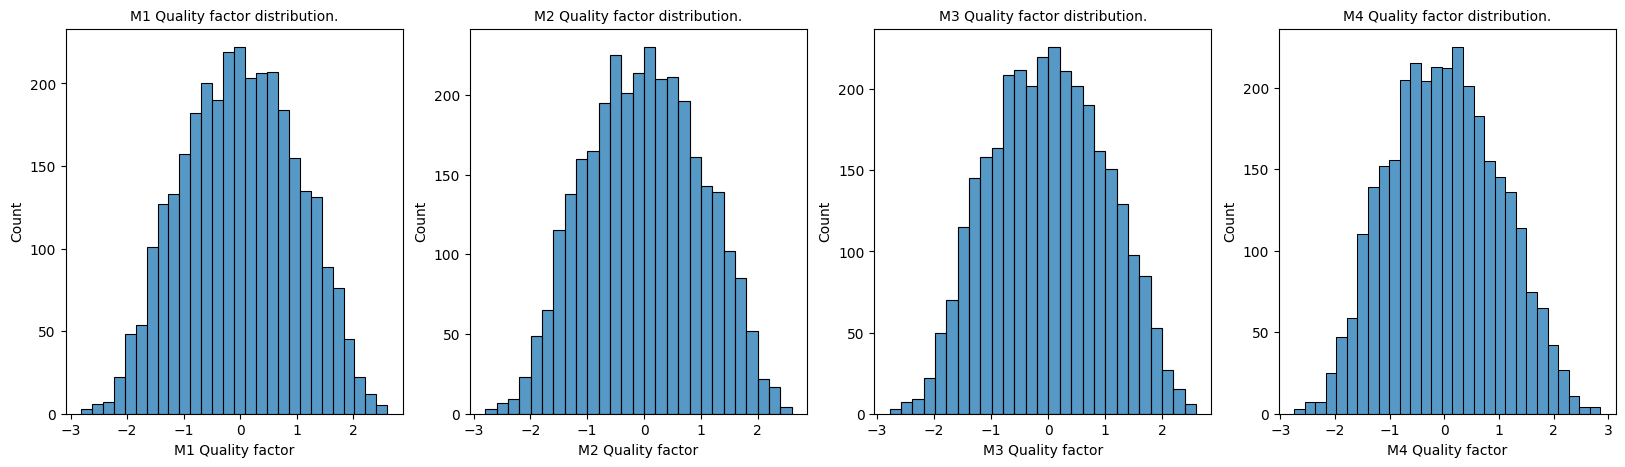

In [ ]:
index_plot = 1
plot_distribution(y_train, indices_to_plot=[1, index_plot + 5, index_plot + 10, index_plot + 15], log_scale=False)

In [ ]:
y_train.describe()

# Обучение моделей

### Специальные функции:

Функция для расчета времени работы модели:

In [ ]:
def get_elapsed_time(model, x_train, num_samples):
    samples_x = x_train.iloc[:num_samples, :]
    time_start = time()
    samples_y = model.predict(samples_x)
    time_stop = time()

    return time_stop - time_start

Функция для вычисления метрик по каждому параметру:

In [ ]:
def calculate_metrics(y_true, y_pred, param_names):
    output_dict = {}
    y_true = y_true.values

    for index, name in enumerate(param_names):
        output_dict[name] = []
        output_dict[name].append(mean_squared_error(y_true[:, index], y_pred[:, index]))
        output_dict[name].append(r2_score(y_true[:, index], y_pred[:, index]))
    
    return output_dict

Функция визуализации метрик по каждому из параметров:

In [ ]:
def plot_metrics(output_dict, param_names=param_save):
    '''
    Необходимо, чтобы последовательность параметров в output_dict для каждой моды 
    совпадала с последовательностью в param_names.
    '''
    fig, ax = plt.subplots(nrows=2, 
                           ncols=len(param_names), 
                           figsize=(5 * len(param_names), 5 * 2), 
                           sharey='row')
    modes = [1, 2, 3, 4]

    # Визуализация метрики MSE
    for index, name in enumerate(param_names):
        points_to_plot = []

        for mode_number in modes:
            points_to_plot.append(output_dict[f'M{mode_number} {name}'][0])

        ax[0, index].plot(modes, points_to_plot)
        ax[0, index].set_title(f"{name} MSE Loss.", fontsize=2 * (len(param_names) + 1))
        ax[0, index].set_xlabel('Mode number')
        ax[0, index].set_ylabel('MSE Loss')
        ax[0, index].set_xticks(modes)
        ax[0, index].grid(visible=True)
    
    # Визуализация метрики R2
    for index, name in enumerate(param_names):
        points_to_plot = []

        for mode_number in modes:
            points_to_plot.append(output_dict[f'M{mode_number} {name}'][1])
        
        ax[1, index].plot(modes, points_to_plot)
        ax[1, index].set_title(f"{name} R2 Score.", fontsize=2 * (len(param_names) + 1))
        ax[1, index].set_xlabel('Mode number')
        ax[1, index].set_ylabel('R2 Score')
        ax[1, index].set_xticks(modes)
        ax[1, index].grid(visible=True)
    
    plt.show()

Функция, которая визуализирует все пять параметров на одном полотне:

In [ ]:
def plot_metrics_dense(output_dict, apply_log_mse, apply_log_r2, param_names=param_save):
    '''
    Необходимо, чтобы последовательность параметров в output_dict для каждой моды 
    совпадала с последовательностью в param_names.
    '''
    fig, ax = plt.subplots(nrows=1, 
                           ncols=2, 
                           figsize=(5 * 2, 5))
    modes = [1, 2, 3, 4]

    # Визуализация метрики MSE
    for name in param_names:
        points_to_plot = []

        for mode_number in modes:
            points_to_plot.append(output_dict[f'M{mode_number} {name}'][0])

        ax[0].plot(modes, points_to_plot, label=f'{name}')
    
    if apply_log_mse:
        ax[0].set_yscale('log')
    
    ax[0].set_title("MSE Loss.", fontsize=2 * 3)
    ax[0].set_xlabel('Mode number')
    ax[0].set_ylabel('MSE Loss')
    ax[0].set_xticks(modes)
    ax[0].grid(visible=True)
    ax[0].legend()

    # Визуализация метрики R2
    for name in param_names:
        points_to_plot = []

        for mode_number in modes:
            points_to_plot.append(output_dict[f'M{mode_number} {name}'][1])

        ax[1].plot(modes, points_to_plot, label=f'{name}')
    
    if apply_log_r2:
        ax[1].set_yscale('log')

    ax[1].set_title("R2 Score.", fontsize=2 * 3)
    ax[1].set_xlabel('Mode number')
    ax[1].set_ylabel('R2 Score')
    ax[1].set_xticks(modes)
    ax[1].grid(visible=True)
    ax[1].legend()
    
    plt.show()

### `LinearRegressor`:

In [ ]:
model_lin = MultiOutputRegressor(LinearRegression(n_jobs=-2))
model_lin.fit(x_train, y_train)

MultiOutputRegressor(estimator=LinearRegression(n_jobs=-2))

In [ ]:
y_pred_train = model_lin.predict(x_train)
y_pred_val = model_lin.predict(x_val)
y_pred_test = model_lin.predict(x_test)

print("MSE на тренировочном наборе: {:.3f}".format(mean_squared_error(y_train, y_pred_train)))
print("MSE на валидационном наборе: {:.3f}".format(mean_squared_error(y_val, y_pred_val)))
print("MSE на тестовом наборе: {:.3f}".format(mean_squared_error(y_test, y_pred_test)))

print("R2 на тренировочном наборе: {:.3f}".format(r2_score(y_train, y_pred_train)))
print("R2 на валидационном наборе: {:.3f}".format(r2_score(y_val, y_pred_val)))
print("R2 на тестовом наборе: {:.3f}".format(r2_score(y_test, y_pred_test)))

print('Metrics dict:')
lin_metrics = calculate_metrics(y_true=y_test, y_pred=y_pred_test, param_names=list(y_train.columns))
for key, value in lin_metrics.items():
    print(key, ' : ', value)

lin_mse_test = mean_squared_error(y_test, y_pred_test)
lin_r2_test = r2_score(y_test, y_pred_test)

MSE на тренировочном наборе: 0.180
MSE на валидационном наборе: 0.203
MSE на тестовом наборе: 0.174
R2 на тренировочном наборе: 0.820
R2 на валидационном наборе: 0.806
R2 на тестовом наборе: 0.817
Metrics dict:
M1 Eigenfrequency (Hz)  :  [0.01536650493332292, 0.9842513549104402]
M1 Quality factor  :  [0.3273097789384859, 0.6459568999322045]
M1 Effective mass (kg)  :  [0.021038243158579623, 0.9781141393078813]
M1 TED (W)  :  [0.08082562558400361, 0.917205352286666]
M1 Noise (kg^2/s^3)  :  [0.32692959642436037, 0.66267541745]
M2 Eigenfrequency (Hz)  :  [0.019724414247065964, 0.9798393608366391]
M2 Quality factor  :  [0.31647917652087637, 0.6590850306170519]
M2 Effective mass (kg)  :  [0.021528830494149526, 0.9775793761027769]
M2 TED (W)  :  [0.07803749669232012, 0.9203057149856898]
M2 Noise (kg^2/s^3)  :  [0.4351771158708086, 0.548427894773986]
M3 Eigenfrequency (Hz)  :  [0.023020781315526092, 0.9765197200373597]
M3 Quality factor  :  [0.3035056315648507, 0.6734733586309503]
M3 Effective

### `RandomForestRegressor`:

In [ ]:
model_forest = RandomForestRegressor(n_estimators=500, 
                                     criterion='squared_error',
                                     random_state=42,
                                     max_depth = 10,
                                     n_jobs=-1) # change depth (lower)
model_forest.fit(x_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=500, n_jobs=-1,
                      random_state=42)

In [ ]:
y_pred_train = model_forest.predict(x_train)
y_pred_val = model_forest.predict(x_val)
y_pred_test = model_forest.predict(x_test)

print("MSE на тренировочном наборе: {:.3f}".format(mean_squared_error(y_train, y_pred_train)))
print("MSE на валидационном наборе: {:.3f}".format(mean_squared_error(y_val, y_pred_val)))
print("MSE на тестовом наборе: {:.3f}".format(mean_squared_error(y_test, y_pred_test)))

print("R2 на тренировочном наборе: {:.3f}".format(r2_score(y_train, y_pred_train)))
print("R2 на валидационном наборе: {:.3f}".format(r2_score(y_val, y_pred_val)))
print("R2 на тестовом наборе: {:.3f}".format(r2_score(y_test, y_pred_test)))

print('Metrics dict:')
forest_metrics = calculate_metrics(y_true=y_test, y_pred=y_pred_test, param_names=list(y_train.columns))
for key, value in forest_metrics.items():
    print(key, ' : ', value)

forest_mse_test = mean_squared_error(y_test, y_pred_test)
forest_r2_test = r2_score(y_test, y_pred_test)

MSE на тренировочном наборе: 0.012
MSE на валидационном наборе: 0.037
MSE на тестовом наборе: 0.038
R2 на тренировочном наборе: 0.988
R2 на валидационном наборе: 0.964
R2 на тестовом наборе: 0.960
Metrics dict:
M1 Eigenfrequency (Hz)  :  [0.024208045153845992, 0.975189939866338]
M1 Quality factor  :  [0.05210223570866161, 0.9436422672411986]
M1 Effective mass (kg)  :  [0.0246832995137557, 0.9743222259336044]
M1 TED (W)  :  [0.017139644370905812, 0.9824428105892468]
M1 Noise (kg^2/s^3)  :  [0.052844431034923464, 0.9454753383177652]
M2 Eigenfrequency (Hz)  :  [0.020839233415049563, 0.9786998863408904]
M2 Quality factor  :  [0.04935542955938809, 0.9468337697851311]
M2 Effective mass (kg)  :  [0.025160164167154483, 0.9737976209094379]
M2 TED (W)  :  [0.01675999792673732, 0.982884176091926]
M2 Noise (kg^2/s^3)  :  [0.06659497763763444, 0.930896103787237]
M3 Eigenfrequency (Hz)  :  [0.01816742394101881, 0.9814699512371721]
M3 Quality factor  :  [0.04824934834801764, 0.9480909214662886]
M3 Ef

Время работы модели:

In [ ]:
print(get_elapsed_time(model=model_forest, x_train=x_train, num_samples=200))

0.1544358730316162


### `XGBRegressor` + `Optuna`:

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 400, 2000),
        'n_jobs': -1,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        #'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        #'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBRegressor(**params)
    optuna_model.fit(x_train, y_train)

    # Make predictions
    y_pred_train = optuna_model.predict(x_train)
    y_pred_val = optuna_model.predict(x_val)
    y_pred_test = optuna_model.predict(x_test)

    # Evaluate metrics
    #mse_train = mean_squared_error(y_train, y_pred_train)
    mse_val = mean_squared_error(y_val, y_pred_val)
    #mse_test = mean_squared_error(y_test, y_pred_test)

    #r2_train = r2_score(y_train, y_pred_train)
    r2_val = r2_score(y_val, y_pred_val)
    #r2_test = r2_score(y_test, y_pred_test)

    return mse_val, r2_val

In [ ]:
study = optuna.create_study(directions=['minimize', 'maximize'])
study.optimize(objective, n_trials=100)

[I 2023-05-13 11:38:32,475] A new study created in memory with name: no-name-3bbe3508-45ea-49b3-9d19-fd7cddf4c576
[I 2023-05-13 11:40:49,810] Trial 0 finished with values: [0.01062785051384105, 0.9898339664847822] and parameters: {'max_depth': 5, 'learning_rate': 0.017635108114570697, 'n_estimators': 1710, 'min_child_weight': 2, 'gamma': 0.002160271263382425, 'subsample': 0.3850474113342906, 'reg_alpha': 2.3419913226074612e-07, 'reg_lambda': 5.490385044606741e-07}. 
[I 2023-05-13 11:41:00,359] Trial 1 finished with values: [0.05624092967962039, 0.9460175870324997] and parameters: {'max_depth': 2, 'learning_rate': 0.04393345549516407, 'n_estimators': 835, 'min_child_weight': 3, 'gamma': 2.8022626495322536e-08, 'subsample': 0.013594724012923646, 'reg_alpha': 0.00010919422292869407, 'reg_lambda': 0.8404624688042207}. 
[I 2023-05-13 11:41:13,075] Trial 2 finished with values: [0.05124483304661145, 0.950798250935809] and parameters: {'max_depth': 2, 'learning_rate': 0.05921131532396252, 'n_

KeyboardInterrupt: ignored

Обучаем модель на найденных оптимальных параметрах:

In [ ]:
#params = trial.params
# Full dataset params
params = {'max_depth': 4, 'learning_rate': 0.014455792961875973, 'n_estimators': 689, 'min_child_weight': 9, 'gamma': 1.4089981359379087e-06, 'subsample': 0.44466289689585464, 'reg_alpha': 0.02764974783890956, 'reg_lambda': 0.027654044172315425}

model_boost_optuna = XGBRegressor(**params)
model_boost_optuna.fit(x_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
y_pred_train = model_boost_optuna.predict(x_train)
y_pred_val = model_boost_optuna.predict(x_val)
y_pred_test = model_boost_optuna.predict(x_test)

print("MSE на тренировочном наборе: {:.3f}".format(mean_squared_error(y_train, y_pred_train)))
print("MSE на валидационном наборе: {:.3f}".format(mean_squared_error(y_val, y_pred_val)))
print("MSE на тестовом наборе: {:.3f}".format(mean_squared_error(y_test, y_pred_test)))

print("R2 на тренировочном наборе: {:.3f}".format(r2_score(y_train, y_pred_train)))
print("R2 на валидационном наборе: {:.3f}".format(r2_score(y_val, y_pred_val)))
print("R2 на тестовом наборе: {:.3f}".format(r2_score(y_test, y_pred_test)))

boost_optuna_mse_test = mean_squared_error(y_test, y_pred_test)
boost_optuna_r2_test = r2_score(y_test, y_pred_test)

MSE на тренировочном наборе: 0.006
MSE на валидационном наборе: 0.028
MSE на тестовом наборе: 0.041
R2 на тренировочном наборе: 0.994
R2 на валидационном наборе: 0.956
R2 на тестовом наборе: 0.950


In [ ]:
metrics = calculate_metrics(y_test=y_test,
                           y_pred=y_pred_test,
                           param_names=list(y_train.columns))
print(metrics)

{'M1 Eigenfrequency (Hz)': [0.02194739010937219, 0.9784854479240462], 'M1 Quality factor': [0.00893993633088701, 0.9908390486045772], 'M1 Effective mass (kg)': [0.0009309959253438732, 0.9990983674549885], 'M1 TED (W)': [0.034175242298529716, 0.9622627549297722], 'M1 Noise (kg^2/s^3)': [0.06252931287721668, 0.60290790299744], 'M2 Eigenfrequency (Hz)': [0.009646845999339262, 0.9905633243195785], 'M2 Quality factor': [0.007435274119501839, 0.9924228448192098], 'M2 Effective mass (kg)': [0.0008889565359394084, 0.9991390119344542], 'M2 TED (W)': [0.03081531221094462, 0.9657149463213964], 'M2 Noise (kg^2/s^3)': [0.06321150444160467, 0.693220036251937], 'M3 Eigenfrequency (Hz)': [0.0077661212074664155, 0.9924590562009993], 'M3 Quality factor': [0.008355843959586787, 0.9914989655293042], 'M3 Effective mass (kg)': [0.001203102041413033, 0.9988243227860946], 'M3 TED (W)': [0.02839494215606317, 0.968729003331364], 'M3 Noise (kg^2/s^3)': [0.10296660591936516, 0.757423538358468], 'M4 Eigenfrequency

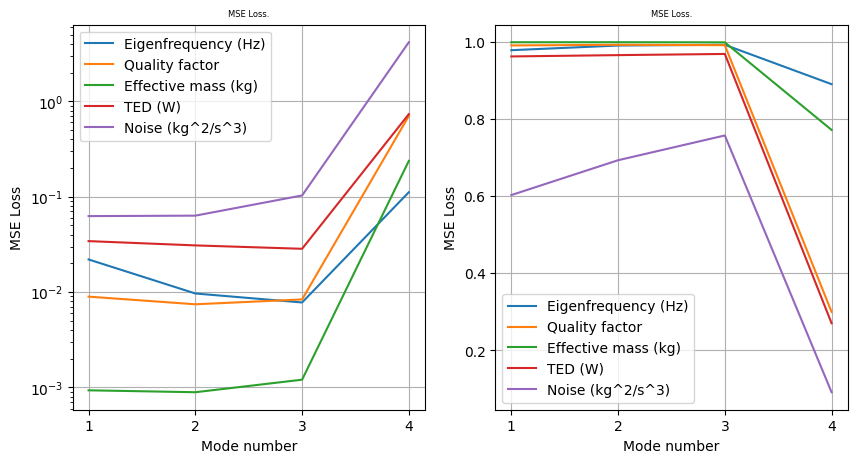

In [ ]:
plot_metrics_dense(output_dict=metrics, apply_log_mse=True, apply_log_r2=False)

### `XGBRegressor`:

In [ ]:
# Basic param choice
#params = {'max_depth': 5, 'learning_rate': 0.01, 'n_estimators': 300, 'n_jobs': -1, 'objective': 'reg:squarederror'}

# Full dataset params
params = {'max_depth': 5, 'learning_rate': 0.017635108114570697, 'n_estimators': 1710, 'min_child_weight': 2, 'gamma': 0.002160271263382425, 'subsample': 0.3850474113342906, 'reg_alpha': 2.3419913226074612e-07, 'reg_lambda': 5.490385044606741e-07, 'n_jobs': -2}

# 200 precise elements params
# params = {'max_depth': 4, 'learning_rate': 0.005211784870189151, 'n_estimators': 1413, 'min_child_weight': 4, 'gamma': 1.2464019738579437e-07, 'subsample': 0.39674390671048576, 'reg_alpha': 4.739413778374957e-05, 'reg_lambda': 3.5895900586501384e-05, 'n_jobs': -1}
model_boost = XGBRegressor(**params)
model_boost.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.002160271263382425, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.017635108114570697, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=1710, n_jobs=-2, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
y_pred_train = model_boost.predict(x_train)
y_pred_val = model_boost.predict(x_val)
y_pred_test = model_boost.predict(x_test)

print("MSE на тренировочном наборе: {:.3f}".format(mean_squared_error(y_train, y_pred_train)))
print("MSE на валидационном наборе: {:.3f}".format(mean_squared_error(y_val, y_pred_val)))
print("MSE на тестовом наборе: {:.3f}".format(mean_squared_error(y_test, y_pred_test)))

print("R2 на тренировочном наборе: {:.3f}".format(r2_score(y_train, y_pred_train)))
print("R2 на валидационном наборе: {:.3f}".format(r2_score(y_val, y_pred_val)))
print("R2 на тестовом наборе: {:.3f}".format(r2_score(y_test, y_pred_test)))

print('Metrics dict:')
boost_metrics = calculate_metrics(y_true=y_test, y_pred=y_pred_test, param_names=list(y_train.columns))
for key, value in boost_metrics.items():
    print(key, ' : ', value)

boost_mse_test = mean_squared_error(y_test, y_pred_test)
boost_r2_test = r2_score(y_test, y_pred_test)

MSE на тренировочном наборе: 0.001
MSE на валидационном наборе: 0.011
MSE на тестовом наборе: 0.010
R2 на тренировочном наборе: 0.999
R2 на валидационном наборе: 0.990
R2 на тестовом наборе: 0.989
Metrics dict:
M1 Eigenfrequency (Hz)  :  [0.0004703392692945045, 0.9995179641528154]
M1 Quality factor  :  [0.01639954594786999, 0.9822610063594239]
M1 Effective mass (kg)  :  [0.0008843682705412277, 0.9990800010902192]
M1 TED (W)  :  [0.0034553561677155495, 0.9964604666581545]
M1 Noise (kg^2/s^3)  :  [0.015880962715034395, 0.9836140894647313]
M2 Eigenfrequency (Hz)  :  [0.0004070040192665195, 0.9995839946845727]
M2 Quality factor  :  [0.01529485015499176, 0.9835242134107303]
M2 Effective mass (kg)  :  [0.0008984890955377018, 0.99906429259628]
M2 TED (W)  :  [0.0032805143453966436, 0.9966498381378589]
M2 Noise (kg^2/s^3)  :  [0.02135447318500451, 0.977841012175356]
M3 Eigenfrequency (Hz)  :  [0.00034417846287132953, 0.9996489516774185]
M3 Quality factor  :  [0.016043503245840796, 0.9827395913

Время работы модели:

In [ ]:
print(get_elapsed_time(model=model_boost, x_train=x_train, num_samples=200))

0.20978999137878418


### `TabNetRegressor`:

In [ ]:
model_tabnet = TabNetRegressor(n_d=16, n_a=16)
model_tabnet.fit(x_train.values, y_train.values, 
                 max_epochs=100,
                 eval_metric=['mse'])

epoch 0  | loss: 2.46732 |  0:00:00s
epoch 1  | loss: 1.09067 |  0:00:00s
epoch 2  | loss: 0.91303 |  0:00:00s
epoch 3  | loss: 0.83726 |  0:00:00s
epoch 4  | loss: 0.75915 |  0:00:00s
epoch 5  | loss: 0.67518 |  0:00:01s
epoch 6  | loss: 0.58223 |  0:00:01s
epoch 7  | loss: 0.49666 |  0:00:01s
epoch 8  | loss: 0.42808 |  0:00:01s
epoch 9  | loss: 0.37734 |  0:00:01s
epoch 10 | loss: 0.33684 |  0:00:01s
epoch 11 | loss: 0.30382 |  0:00:02s
epoch 12 | loss: 0.27082 |  0:00:02s
epoch 13 | loss: 0.24309 |  0:00:02s
epoch 14 | loss: 0.21897 |  0:00:02s
epoch 15 | loss: 0.19674 |  0:00:02s
epoch 16 | loss: 0.17954 |  0:00:02s
epoch 17 | loss: 0.15804 |  0:00:03s
epoch 18 | loss: 0.14317 |  0:00:03s
epoch 19 | loss: 0.13457 |  0:00:03s
epoch 20 | loss: 0.12766 |  0:00:03s
epoch 21 | loss: 0.11724 |  0:00:03s
epoch 22 | loss: 0.11502 |  0:00:03s
epoch 23 | loss: 0.11233 |  0:00:04s
epoch 24 | loss: 0.10461 |  0:00:04s
epoch 25 | loss: 0.10567 |  0:00:04s
epoch 26 | loss: 0.09806 |  0:00:04s
e

In [ ]:
y_pred_train = model_tabnet.predict(x_train.values)
y_pred_val = model_tabnet.predict(x_val.values)
y_pred_test = model_tabnet.predict(x_test.values)

print("MSE на тренировочном наборе: {:.3f}".format(mean_squared_error(y_train, y_pred_train)))
print("MSE на валидационном наборе: {:.3f}".format(mean_squared_error(y_val, y_pred_val)))
print("MSE на тестовом наборе: {:.3f}".format(mean_squared_error(y_test, y_pred_test)))

print("R2 на тренировочном наборе: {:.3f}".format(r2_score(y_train, y_pred_train)))
print("R2 на валидационном наборе: {:.3f}".format(r2_score(y_val, y_pred_val)))
print("R2 на тестовом наборе: {:.3f}".format(r2_score(y_test, y_pred_test)))

print('Metrics dict:')
tabnet_metrics = calculate_metrics(y_true=y_test, y_pred=y_pred_test, param_names=list(y_train.columns))
for key, value in tabnet_metrics.items():
    print(key, ' : ', value)

tabnet_mse_test = mean_squared_error(y_test, y_pred_test)
tabnet_r2_test = r2_score(y_test, y_pred_test)

MSE на тренировочном наборе: 0.037
MSE на валидационном наборе: 0.038
MSE на тестовом наборе: 0.037
R2 на тренировочном наборе: 0.963
R2 на валидационном наборе: 0.963
R2 на тестовом наборе: 0.961
Metrics dict:
M1 Eigenfrequency (Hz)  :  [0.02857248878732745, 0.9707169595695604]
M1 Quality factor  :  [0.053288441252878814, 0.9423591772902834]
M1 Effective mass (kg)  :  [0.02389304591923412, 0.9751443183464916]
M1 TED (W)  :  [0.015507439688343207, 0.9841147779970136]
M1 Noise (kg^2/s^3)  :  [0.04647572757912859, 0.952046539757179]
M2 Eigenfrequency (Hz)  :  [0.02119365477817705, 0.9783376265990142]
M2 Quality factor  :  [0.05042696833891462, 0.9456794960214328]
M2 Effective mass (kg)  :  [0.024842430050572316, 0.9741285165950694]
M2 TED (W)  :  [0.013493192702420543, 0.9862203377791648]
M2 Noise (kg^2/s^3)  :  [0.05715182265187136, 0.9406950229430928]
M3 Eigenfrequency (Hz)  :  [0.01778380232023086, 0.9818612300097022]
M3 Quality factor  :  [0.04890377858101287, 0.9473868524680017]
M3 

### `TabNetRegressor` + `Optuna`

In [ ]:
def objective(trial):
    """Define the objective function"""
    '''
    params = {
        'n_d': trial.suggest_int('n_d', 2, 32),
        'n_a': trial.suggest_int('n_a', 2, 32),
        'n_steps': trial.suggest_int('n_steps', 2, 16),
        #'momentum': trial.suggest_loguniform('momentum', 0.001, 0.1),
        'verbose': 0
    }
    '''

    n = trial.suggest_int('n', 2, 64)
    n_steps = trial.suggest_int('n_steps', 2, 32)
    momentum = trial.suggest_loguniform('momentum', 0.001, 0.1)

    # Fit the model
    optuna_model = TabNetRegressor(n_a = n, n_d = n, n_steps = n_steps, momentum=momentum, verbose=0)
    optuna_model.fit(x_train.values, y_train.values)

    # Make predictions
    y_pred_train = optuna_model.predict(x_train.values)
    y_pred_val = optuna_model.predict(x_val.values)
    y_pred_test = optuna_model.predict(x_test.values)

    # Evaluate metrics
    #mse_train = mean_squared_error(y_train, y_pred_train)
    mse_val = mean_squared_error(y_val, y_pred_val)
    #mse_test = mean_squared_error(y_test, y_pred_test)

    #r2_train = r2_score(y_train, y_pred_train)
    r2_val = r2_score(y_val, y_pred_val)
    #r2_test = r2_score(y_test, y_pred_test)

    return mse_val, r2_val

In [ ]:
study = optuna.create_study(directions=['minimize', 'maximize'])
study.optimize(objective, n_trials=100)

[I 2023-04-10 06:48:51,127] A new study created in memory with name: no-name-d602bec1-4c87-478e-b821-3048ef513af7
[I 2023-04-10 06:51:02,554] Trial 0 finished with values: [0.13961886038180168, 0.8646185198454092] and parameters: {'n': 43, 'n_steps': 7, 'momentum': 0.0010793203993273717}. 
[I 2023-04-10 06:52:02,958] Trial 1 finished with values: [0.17329390548741955, 0.8309252289730822] and parameters: {'n': 6, 'n_steps': 10, 'momentum': 0.005051250105708748}. 
[I 2023-04-10 06:59:10,893] Trial 2 finished with values: [0.23529312764651822, 0.7674008847044388] and parameters: {'n': 47, 'n_steps': 28, 'momentum': 0.01281107369409564}. 
[I 2023-04-10 07:01:59,627] Trial 3 finished with values: [0.13424968675784987, 0.8702789170995148] and parameters: {'n': 44, 'n_steps': 12, 'momentum': 0.011635152774156443}. 
[I 2023-04-10 07:05:52,340] Trial 4 finished with values: [0.12684461656385723, 0.8778096463294462] and parameters: {'n': 57, 'n_steps': 12, 'momentum': 0.026932465912731518}. 
[I 

In [ ]:
TabNetRegressor()

### `XGBRegressor` + Crossvalidation:

In [ ]:
# Параметры для обучения XGBRegressor
params = {'max_depth': 4, 'learning_rate': 0.03271548065350945, 'n_estimators': 649, 'min_child_weight': 4, 'gamma': 0.02042974114124899, 'subsample': 0.5897894074978374, 'reg_alpha': 2.798449894027825e-08, 'reg_lambda': 0.06927996637344778, 'n_jobs': -1}

# Создание модели XGBRegressor
model_xgb_CV = XGBRegressor(**params)

# Данные для кроссвалидации
x_trainval = pd.concat([x_train, x_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

# Кроссвалидация
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
score_xgb = cross_validate(model_xgb_CV,
                           x_trainval.values,
                           y_trainval.values,
                           scoring=['neg_mean_squared_error', 'r2'],
                           cv=kf,
                           n_jobs=-1)

In [ ]:
# Результаты
print(f"Score for params = {params}:")
print(score_xgb)

Score for params = {'max_depth': 4, 'learning_rate': 0.03271548065350945, 'n_estimators': 649, 'min_child_weight': 4, 'gamma': 0.02042974114124899, 'subsample': 0.5897894074978374, 'reg_alpha': 2.798449894027825e-08, 'reg_lambda': 0.06927996637344778, 'n_jobs': -1}:
{'fit_time': array([169.54168701, 170.89781594, 147.4225378 , 147.18861961,
       149.49535155, 149.12107301, 147.20275092, 146.83460641,
       146.25537109, 145.42497182]), 'score_time': array([0.21902537, 0.2198627 , 0.2200954 , 0.22019935, 0.23823547,
       0.24004745, 0.43772435, 0.40118194, 0.21593451, 0.2709775 ]), 'test_neg_mean_squared_error': array([-0.11932416, -0.11172532, -0.10603945, -0.11732596, -0.11364879,
       -0.10922518, -0.10890884, -0.10986   , -0.11768716, -0.10174994]), 'test_r2': array([0.88628709, 0.89376869, 0.89084308, 0.88596199, 0.8880182 ,
       0.88988428, 0.89182986, 0.88787939, 0.88281689, 0.89609739])}


### XGBRegressor + Custom Cross-validation

#### Кастомная кросс-валидация:

In [ ]:
class Custom_KFold():



    def __init__(self, model, n_splits, fitting_params=None, shuffle=True, random_state=42):
        '''
        model - необученная модель, в которую уже загружены параметры обучения
        n_splits - количество фолдов в крос-валидации
        fitting_params - количество параметров, которые будут использованы (идут в порядке слева направо)
        shuffle - нужно ли перемешивать выборку при кросс-валидации
        '''
        self.kf_sklearn = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
        self.model = model
        self.n_splits = n_splits
        self.fitting_params = fitting_params

        # Логи индексов
        self.train_indices_log = []
        self.val_indices_log = []

        # Лог метрик
        self.metrics_log = []

        # Лог предсказаний модели
        self.y_pred_train_log = []
        self.y_pred_val_log = []

        self.x_trainval = None
        self.y_trainval = None

        self.param_names_x = None
        self.param_names_y = None



    # Функция, осуществляющая кастомную кросс-валидацию
    def cross_validate(self, x_trainval, y_trainval, return_indices):
        '''
        return_indices - если True, то вернет лог с индексами фолдов
        '''
        # Копируем данные
        self.x_trainval = x_trainval
        self.y_trainval = y_trainval

        # Копируем названия колонок в Х и У
        self.param_names_x = list(x_trainval.columns)
        self.param_names_y = list(y_trainval.columns)

        output_dict = {}
        counter = 1
        param_names = list(y_trainval.columns)

        # Итерируемся по фолдам
        for train_indices, val_indices in tqdm(self.kf_sklearn.split(x_trainval.values, y_trainval.values)):
            
            # Преобразование индексов в тип int
            train_indices = train_indices.astype('int')
            val_indices = val_indices.astype('int')

            # Сохраняем индексы в логи
            self.train_indices_log.append(train_indices)
            self.val_indices_log.append(val_indices)

            # Создаем свежую модель и обучаем ее, делаем предсказания
            model = clone(self.model)
            model.fit(x_trainval.iloc[train_indices, :].values, y_trainval.iloc[train_indices, :].values)

            y_pred_train = model.predict(x_trainval.iloc[train_indices, :].values)
            y_pred_val = model.predict(x_trainval.iloc[val_indices, :].values)

            self.metrics_log.append(calculate_metrics(y_true=y_trainval.iloc[val_indices, :], y_pred=y_pred_val, param_names=param_names))

            print(f' Fold N{counter} is processed!')
            counter += 1

            # Сохраняем значения предсказаний в отдельные логи
            self.y_pred_train_log.append(y_pred_train)
            self.y_pred_val_log.append(y_pred_val)
        
        if return_indices:
            return self.metrics_log, self.train_indices_log, self.val_indices_log
        else:
            return self.metrics_log



    # Функция, возвращающая два объекта 'ax', на которых визуализируются метрики MSE и R2 для всех мод и параметров
    def plot_metrics_dense(self, fold_index, apply_log_mse, apply_log_r2, param_names=param_save):
        '''
        Необходимо, чтобы последовательность параметров в output_dict для каждой моды 
        совпадала с последовательностью в param_names.
        '''
        fig, ax = plt.subplots(nrows=1, 
                            ncols=2, 
                            figsize=(5 * 2, 5))
        modes = [1, 2, 3, 4]

        # Визуализация метрики MSE
        for name in param_names:
            points_to_plot = []

            for mode in modes:
                points_to_plot.append(self.metrics_log[fold_index][f'M{mode} ' + f'{name}'][0])

            ax[0].plot(modes, points_to_plot, label=f'{name}')
        
        if apply_log_mse:
            ax[0].set_yscale('log')
        
        ax[0].set_title("MSE Loss.", fontsize=2 * 3)
        ax[0].set_xlabel('Mode number')
        ax[0].set_ylabel('MSE Loss')
        ax[0].set_xticks(modes)
        ax[0].grid(visible=True)
        ax[0].legend()

        # Визуализация метрики R2
        for name in param_names:
            points_to_plot = []

            for mode in modes:
                points_to_plot.append(self.metrics_log[fold_index][f'M{mode} ' + f'{name}'][1])

            ax[1].plot(modes, points_to_plot, label=f'{name}')
        
        if apply_log_r2:
            ax[1].set_yscale('log')

        ax[1].set_title("R2 Score.", fontsize=2 * 3)
        ax[1].set_xlabel('Mode number')
        ax[1].set_ylabel('R2 Score')
        ax[1].set_xticks(modes)
        ax[1].grid(visible=True)
        ax[1].legend()
        
        return ax[0], ax[1]



    # Визуализирует распределение исходных данных и предсказаний модели на определенном фолде для тренировочной части и валидационной части фолда
    def plot_distribution_trainval(self, fold_index, log_scale):
        x_col_len, y_col_len = len(self.param_names_x), len(self.param_names_y)

        # Итерируемся по всем фолдам - deprecated!
        #for fold_index in tqdm(range(0, self.n_splits)):

        # Визуализация значений метрик для данного фолда
        print('Started plotting metrics.')
        fig_metrics, ax_metrics = plt.subplots(nrows=1, ncols=2, figsize=(5 * 2, 5))
        ax_metrics[0], ax_metrics[1] = self.plot_metrics_dense(fold_index=fold_index,
                                                    apply_log_mse=True,
                                                    apply_log_r2=False) 
        print('Metrics have been successfully plotted!')


        # ======
        # Итерируемся по всем параметрам в X-данных
        print('Started plotting X-data distribution.')
        fig_x, ax_x = plt.subplots(nrows=1, ncols=x_col_len, figsize=(10 * x_col_len, 15))
        for index in tqdm(range(0, x_col_len)):
            # Рисуем распределение тренировочного фолда в x-данных
            sns.histplot(self.x_trainval.iloc[self.train_indices_log[fold_index], index], 
                            ax=ax_x[index],
                            element="step",
                            log_scale=log_scale)
            
            # Рисуем распределение валидационного фолда в x-данных
            sns.histplot(self.x_trainval.iloc[self.val_indices_log[fold_index], index], 
                            ax=ax_x[index],
                            element="step",
                            log_scale=log_scale)
            
            ax_x[index].set_title(f"{self.param_names_x[index]} distribution.", 
                                                        fontsize=20)
            ax_x[index].set_xlabel(self.param_names_x[index])
            ax_x[index].set_ylabel('Count')
        print('X-data distribution has been successfully plotted!')


        # ======
        # Итерируемся по всем параметрам в у-данных
        print('Started plotting Y-data distribution.')
        fig_y, ax_y = plt.subplots(nrows=4, ncols=int(y_col_len / 4), figsize=(50, 40))
        for index in tqdm(range(0, y_col_len)):
            if 'M1' in self.param_names_y[index]:
                mode = 0
            elif 'M2' in self.param_names_y[index]:
                mode = 1
            elif 'M3' in self.param_names_y[index]:
                mode = 2
            elif 'M4' in self.param_names_y[index]:
                mode = 3

            # Рисуем распределение тренировочного фолда в у-данных
            sns.histplot(self.y_trainval.iloc[self.train_indices_log[fold_index], index], 
                         ax=ax_y[mode, index - 5 * mode],
                         element="step",
                         log_scale=log_scale)
            
            # Рисуем распределение валидационного фолда в у-данных
            sns.histplot(self.y_trainval.iloc[self.val_indices_log[fold_index], index], 
                         ax=ax_y[mode, index - 5 * mode],
                         element="step",
                         log_scale=log_scale)
            
            # Рисуем распределение тренировочного фолда (предсказания) в у-данных
            sns.histplot(self.y_pred_train_log[fold_index][:, index], 
                         ax=ax_y[mode, index - 5 * mode],
                         element="step",
                         fill=False,
                         color='k',
                         log_scale=log_scale)
            
            # Рисуем распределение валидационного фолда (предсказания ) в у-данных
            sns.histplot(self.y_pred_val_log[fold_index][:, index], 
                         ax=ax_y[mode, index - 5 * mode],
                         element="step",
                         fill=False,
                         color='k',
                         log_scale=log_scale)
            
            ax_y[mode, index - 5 * mode].set_title(f"{self.param_names_y[index]} distribution. MSE = {self.metrics_log[fold_index][self.param_names_y[index]][0]:.3f}, R2 = {self.metrics_log[fold_index][self.param_names_y[index]][1]:.3f}", 
                                                        fontsize=12)
            ax_y[mode, index - 5 * mode].set_xlabel(self.param_names_y[index])
            ax_y[mode, index - 5 * mode].set_ylabel('Count')
        print('Y-data disribution has been successfully plotted!')
        plt.plot()

#### Выполнение кастомной кросс-валидации:

In [ ]:
# Параметры для обучения XGBRegressor
params = {'max_depth': 4, 'learning_rate': 0.03271548065350945, 'n_estimators': 649, 'min_child_weight': 4, 'gamma': 0.02042974114124899, 'subsample': 0.5897894074978374, 'reg_alpha': 2.798449894027825e-08, 'reg_lambda': 0.06927996637344778, 'n_jobs': -1}

# Создание модели XGBRegressor
model_xgb_CV = XGBRegressor(**params)

# Данные для кроссвалидации
x_trainval = pd.concat([x_train, x_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

kf = Custom_KFold(model=model_xgb_CV, n_splits=10, shuffle=True, random_state=42)
metrics_log, train_indices_log, val_indices_log = kf.cross_validate(x_trainval=x_trainval, y_trainval=y_trainval, return_indices=True)

1it [01:22, 82.86s/it]

 Fold N1 is processed!


2it [02:50, 85.46s/it]

 Fold N2 is processed!


3it [04:14, 85.10s/it]

 Fold N3 is processed!


4it [05:42, 86.04s/it]

 Fold N4 is processed!


5it [07:09, 86.35s/it]

 Fold N5 is processed!


6it [08:35, 86.42s/it]

 Fold N6 is processed!


7it [10:03, 86.79s/it]

 Fold N7 is processed!


8it [11:32, 87.44s/it]

 Fold N8 is processed!


9it [12:58, 87.20s/it]

 Fold N9 is processed!


10it [14:22, 86.29s/it]

 Fold N10 is processed!


In [ ]:
print(metrics_log)
print(train_indices_log[0][0:50])

[{'M1 Eigenfrequency (Hz)': [0.02610194789553149, 0.970304883089075], 'M1 Quality factor': [0.0071923038400339805, 0.9929478144540101], 'M1 Effective mass (kg)': [0.0009842816880939731, 0.9990390881148291], 'M1 TED (W)': [0.03321040563338055, 0.9667413035940672], 'M1 Noise (kg^2/s^3)': [0.008374910548033765, 0.9917279428518654], 'M2 Eigenfrequency (Hz)': [0.011020235600736252, 0.9873676924300568], 'M2 Quality factor': [0.0057493468038318325, 0.9943461971420147], 'M2 Effective mass (kg)': [0.0009354082638380203, 0.9990892015109867], 'M2 TED (W)': [0.03327791008043378, 0.9660318596955395], 'M2 Noise (kg^2/s^3)': [0.0043765257163357555, 0.9956736208600655], 'M3 Eigenfrequency (Hz)': [0.007716232777235553, 0.9911976085126799], 'M3 Quality factor': [0.005454800080774872, 0.9945990622798543], 'M3 Effective mass (kg)': [0.0015009185735237534, 0.9985284951418745], 'M3 TED (W)': [0.028605474224795625, 0.9704602103751561], 'M3 Noise (kg^2/s^3)': [0.0035663373007824915, 0.996483060581333], 'M4 Ei

Started plotting metrics.
Metrics have been successfully plotted!
Started plotting X-data distribution.


100%|██████████| 7/7 [00:00<00:00, 17.44it/s]


X-data distribution has been successfully plotted!
Started plotting Y-data distribution.


100%|██████████| 20/20 [00:01<00:00, 12.38it/s]


Y-data disribution has been successfully plotted!


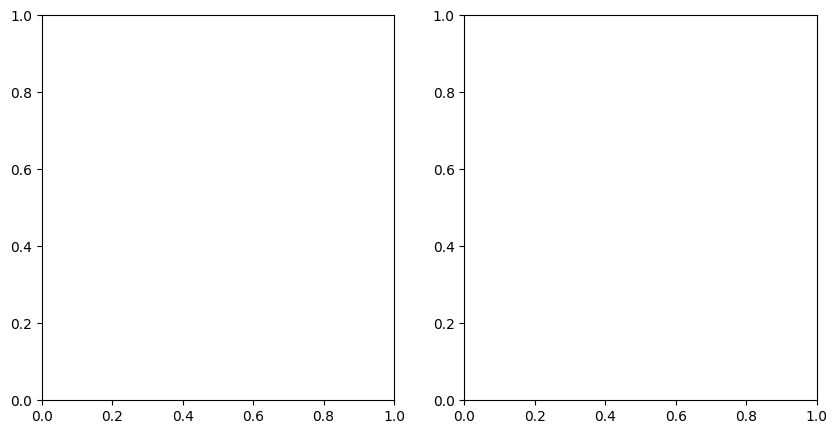

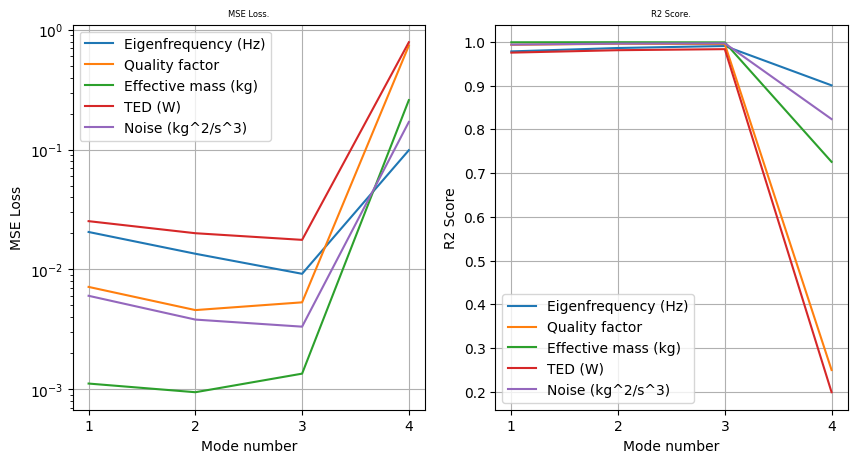

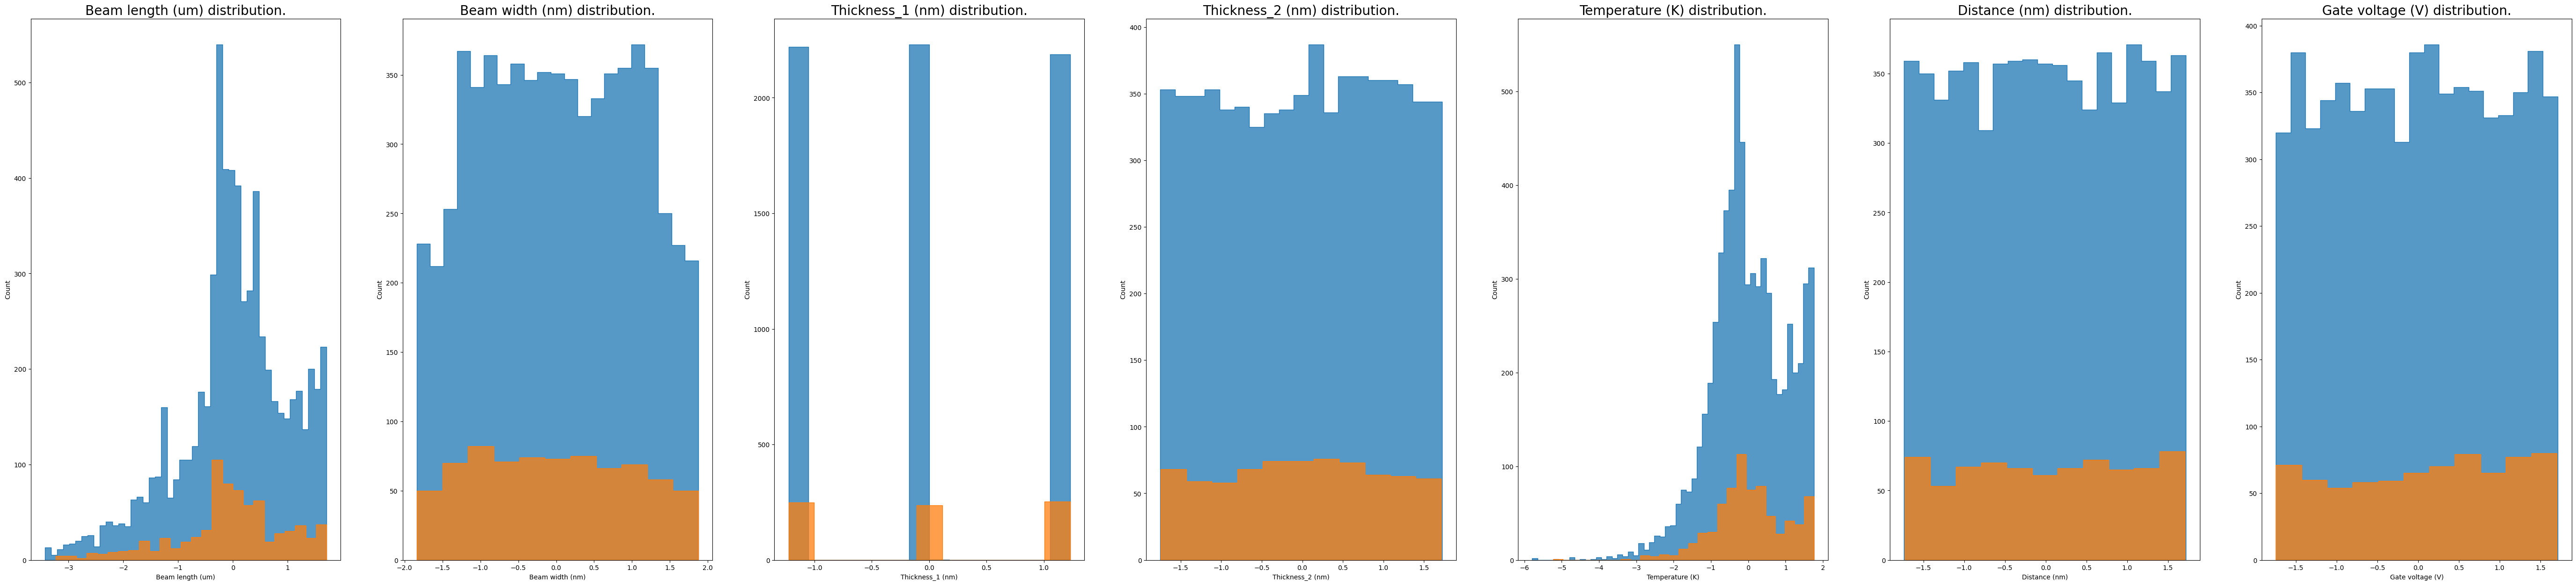

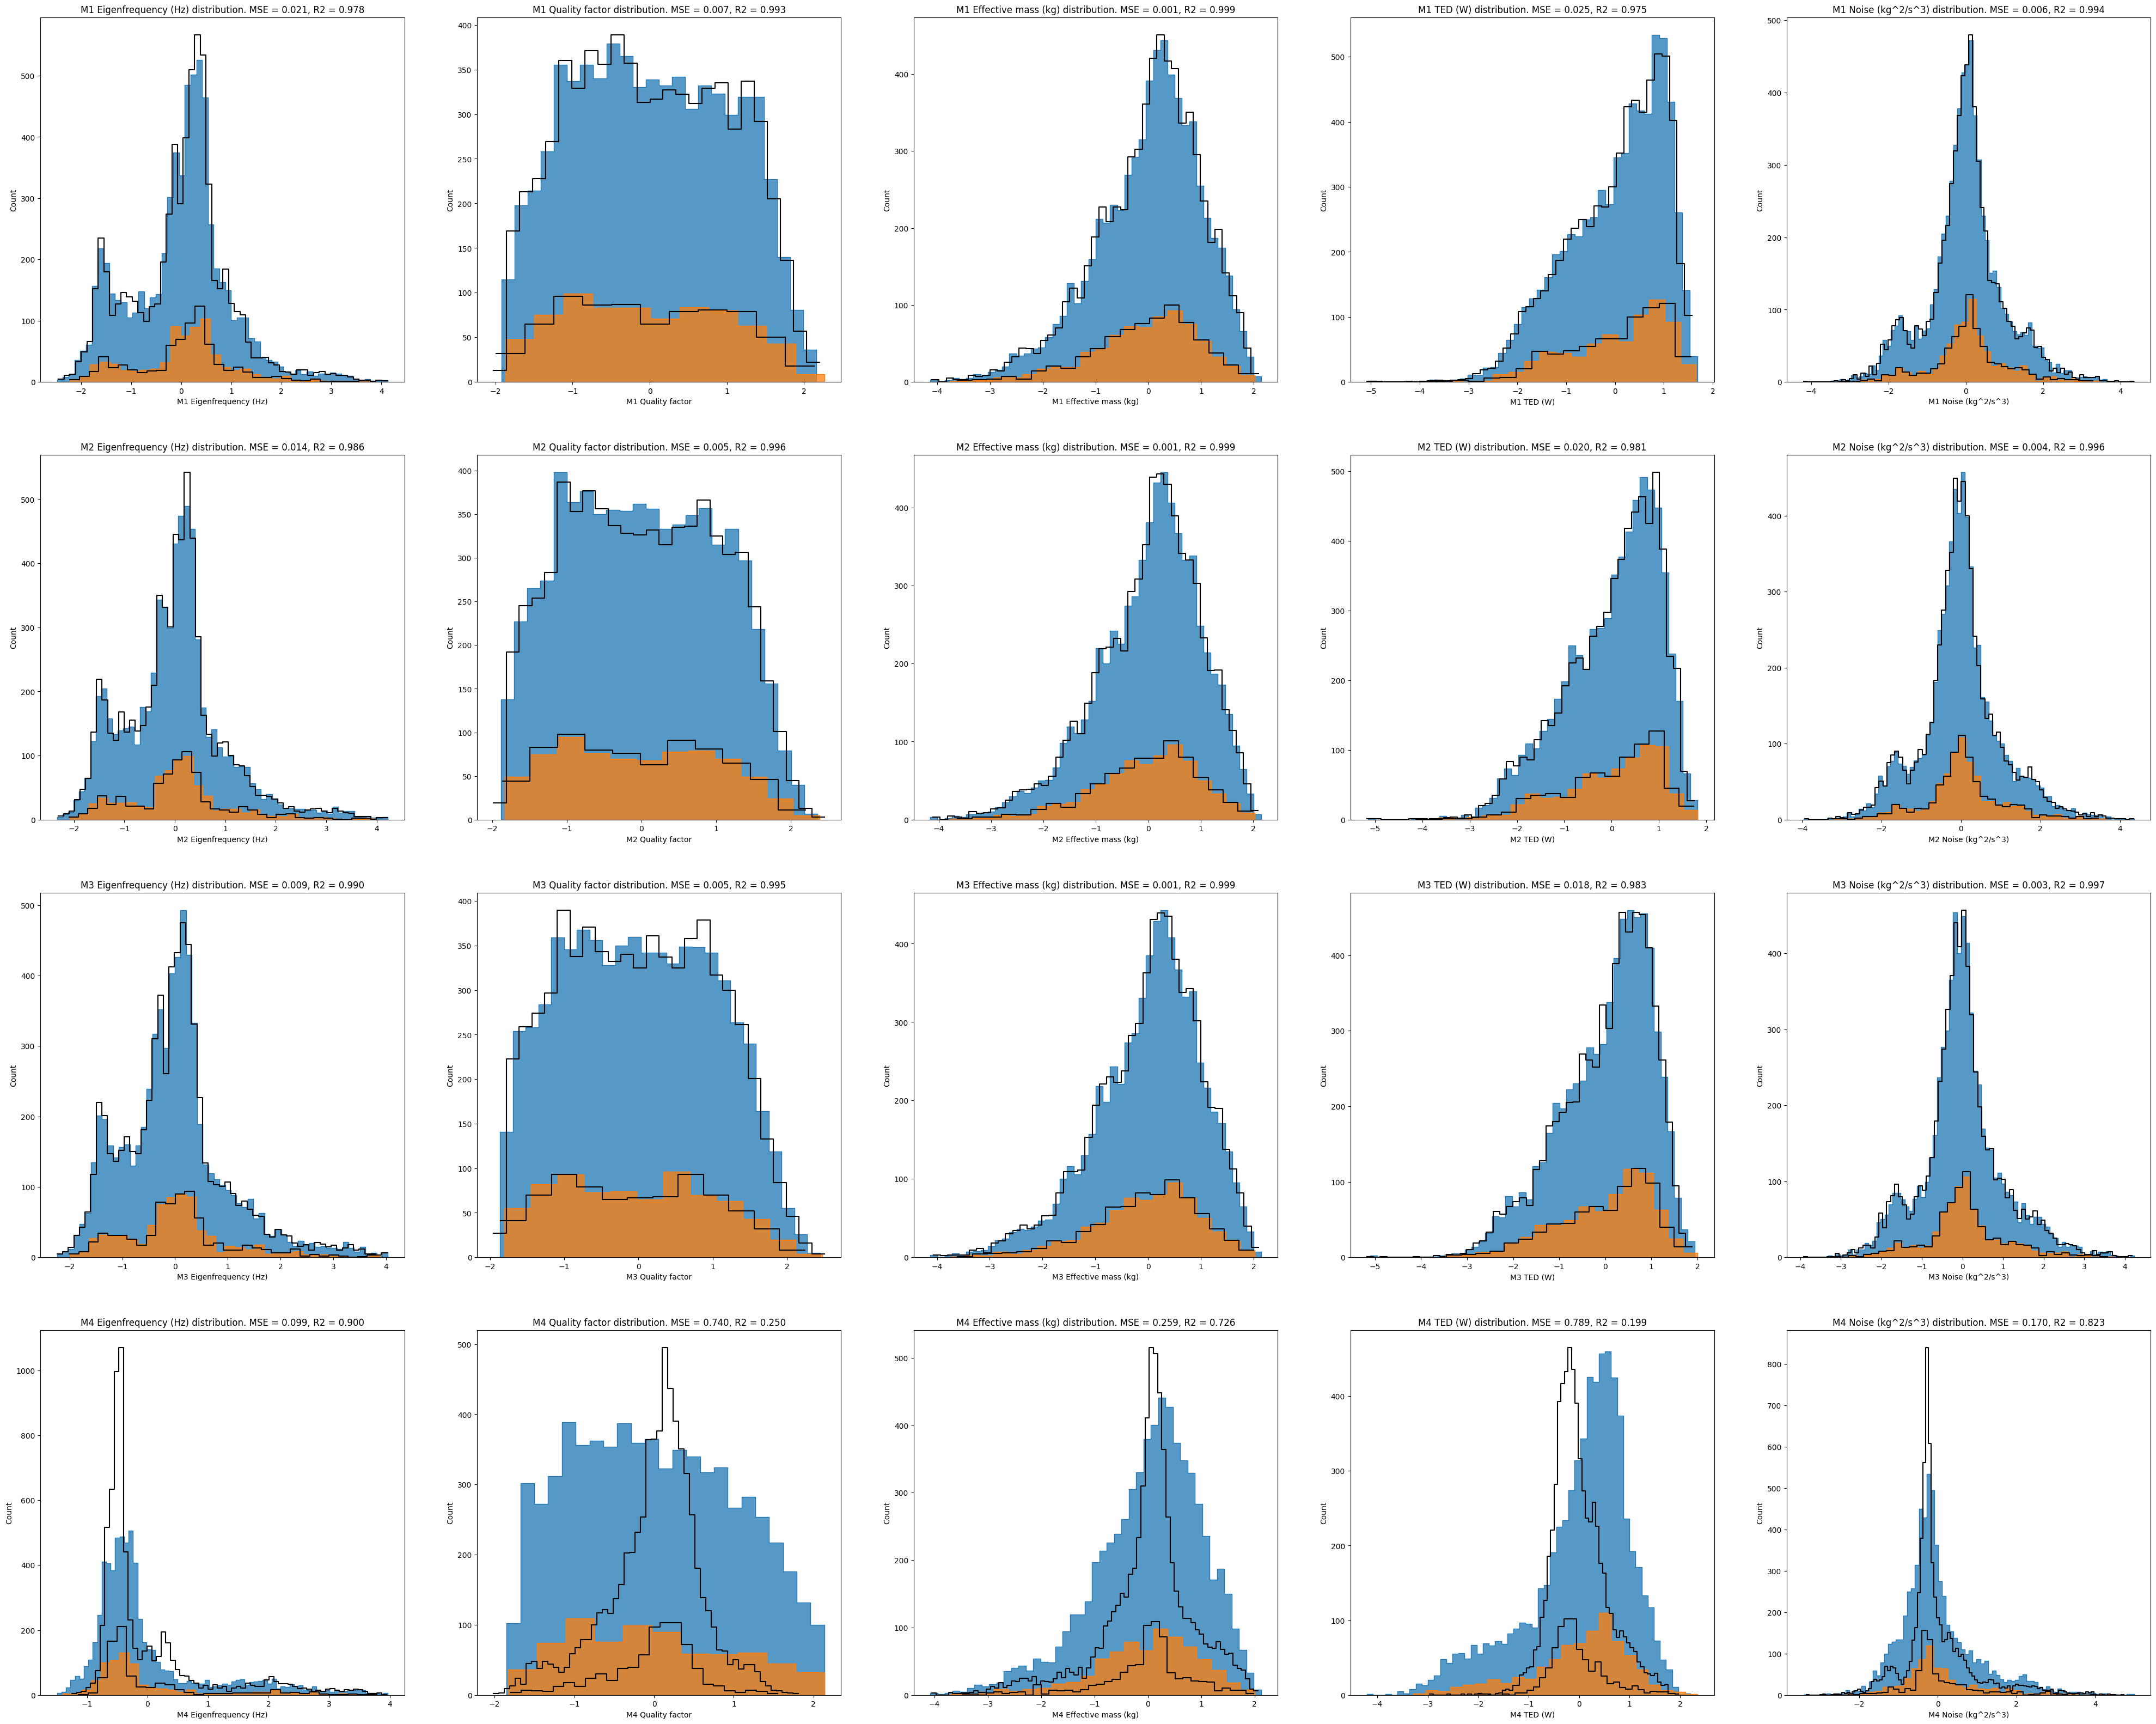

In [ ]:
kf.plot_distribution_trainval(fold_index=7, log_scale=False)

#### Анализ метрик на каждом фолде:

Fold N1;  MSE Loss: 0.112;  R2 Score: 0.648  


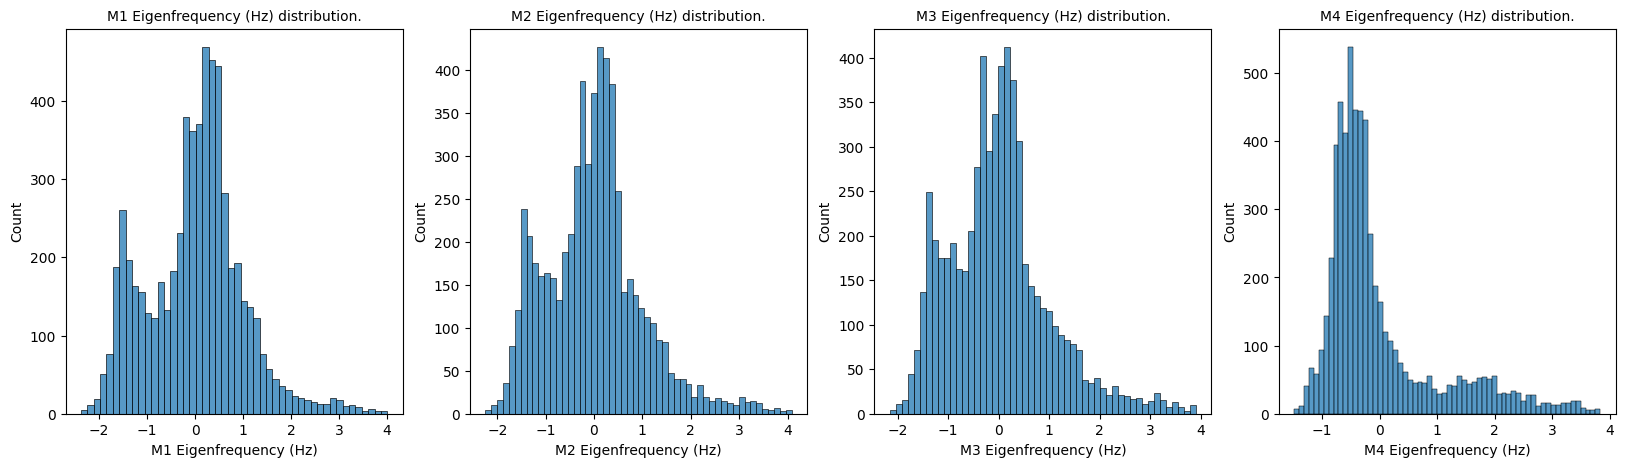

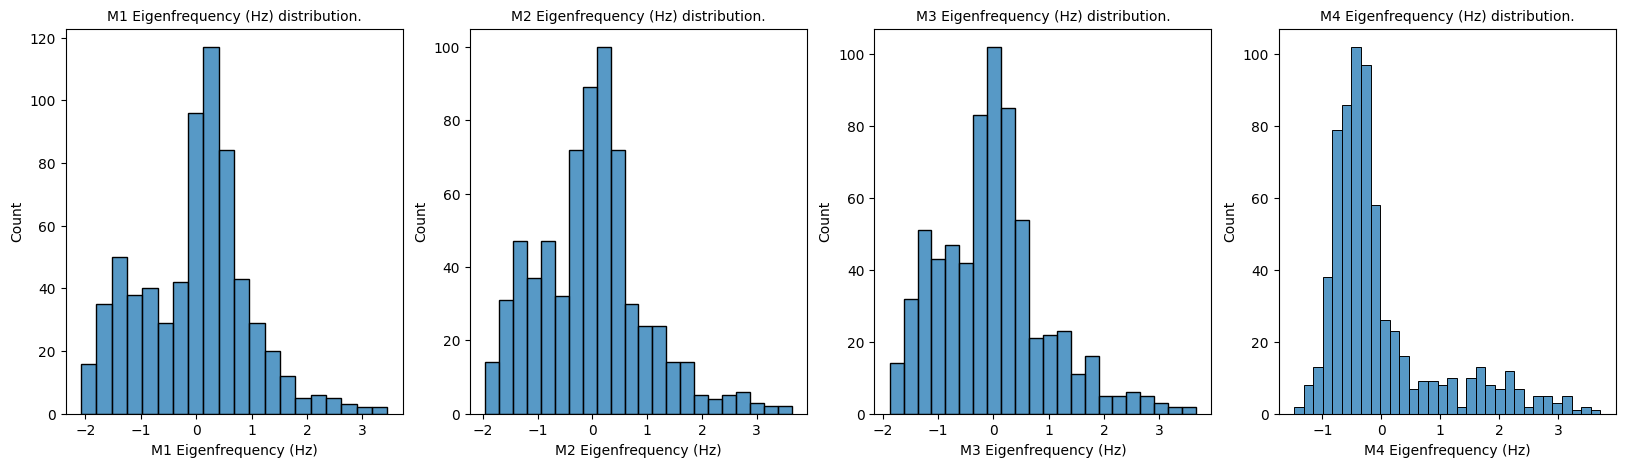

Fold N2;  MSE Loss: 0.166;  R2 Score: 0.809  


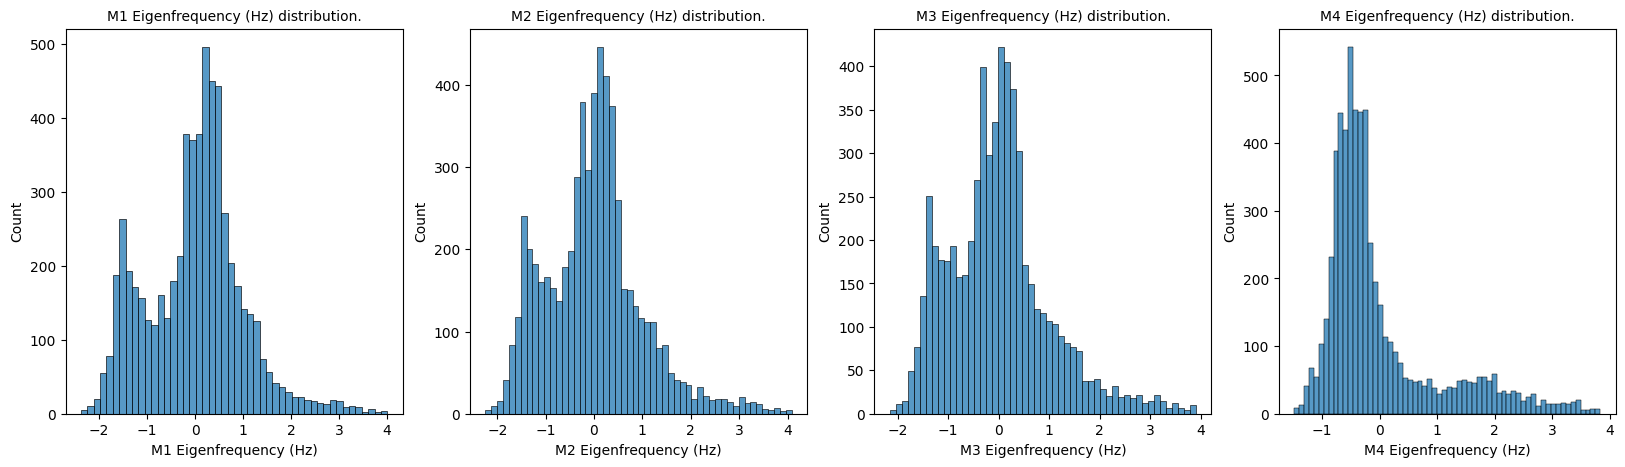

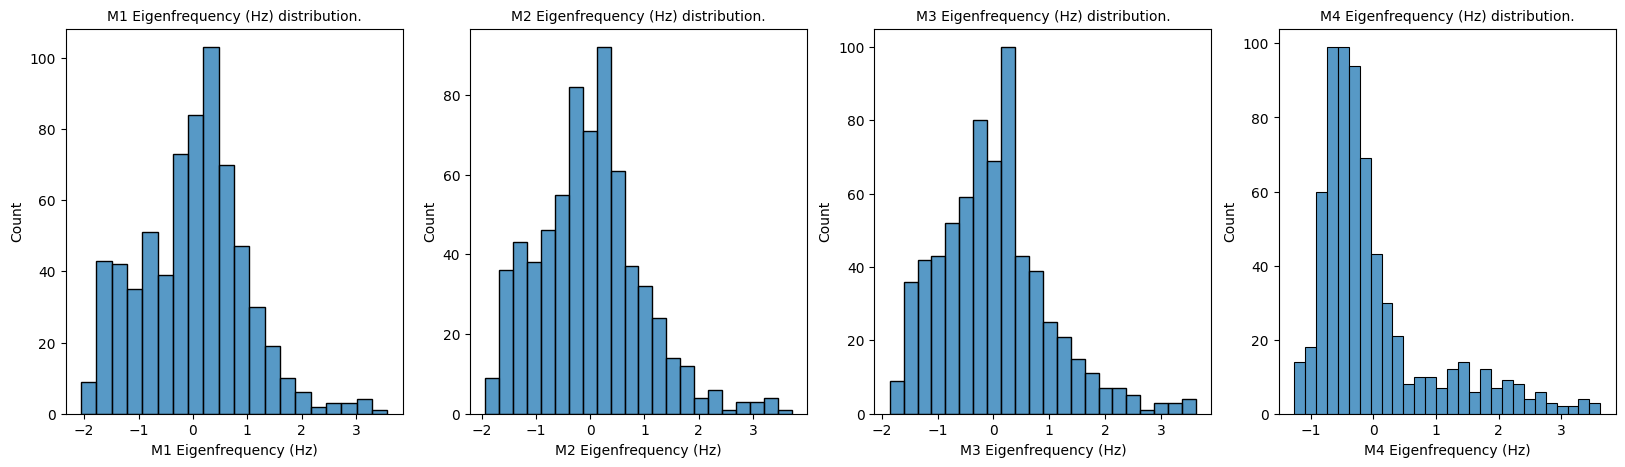

Fold N3;  MSE Loss: 0.139;  R2 Score: 0.684  


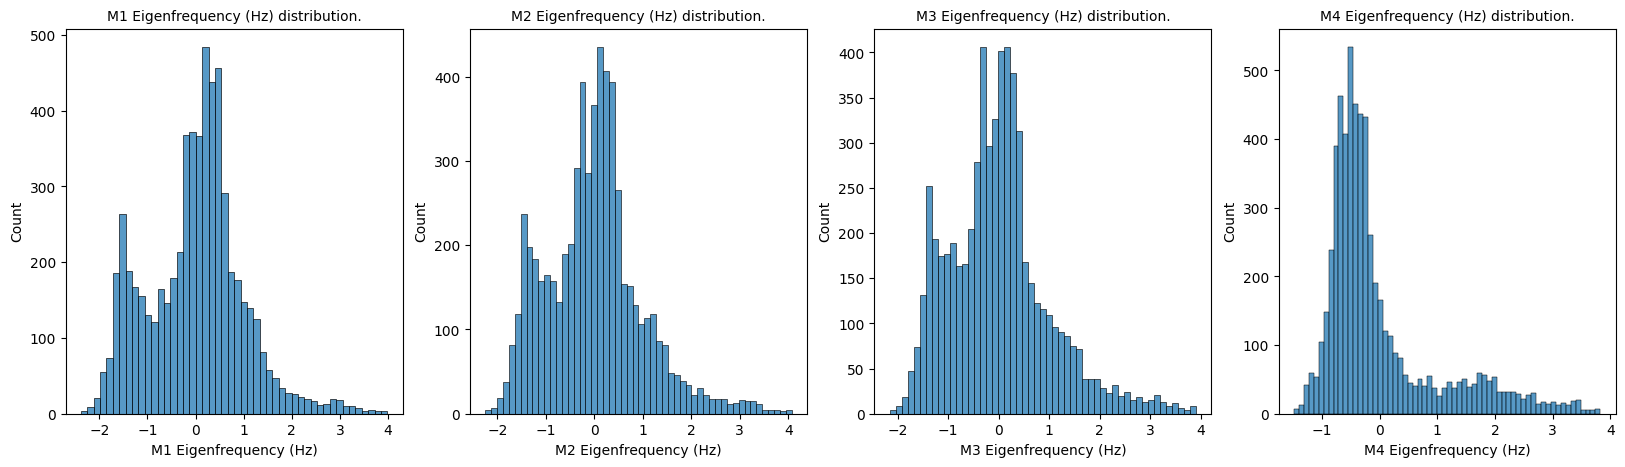

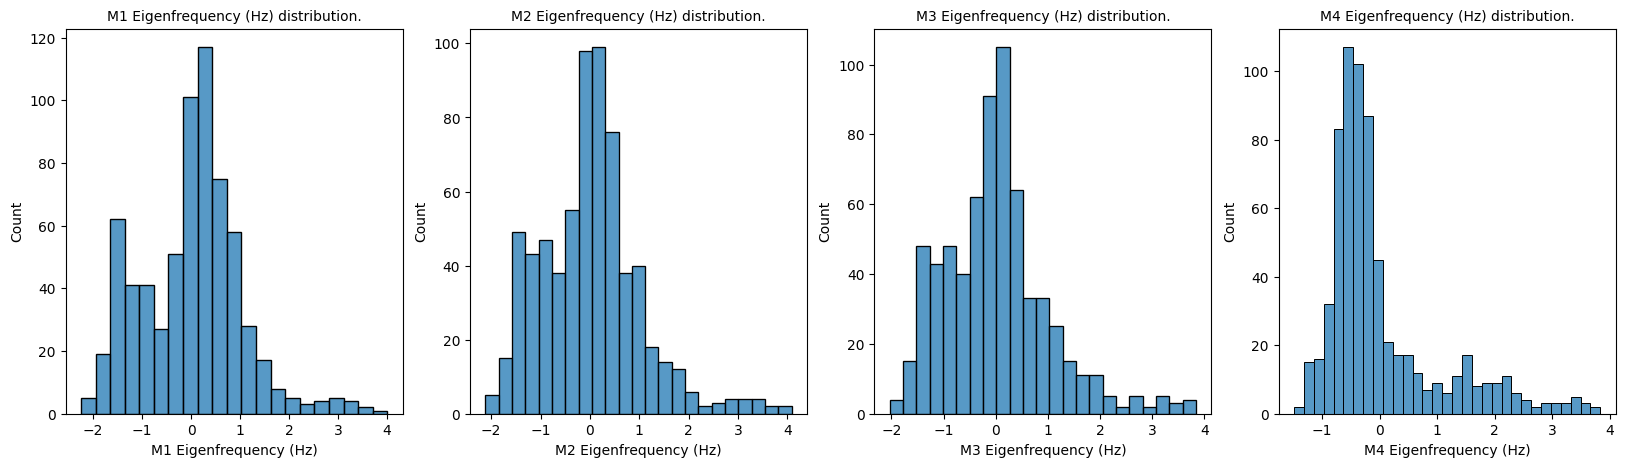

Fold N4;  MSE Loss: 0.415;  R2 Score: 0.786  


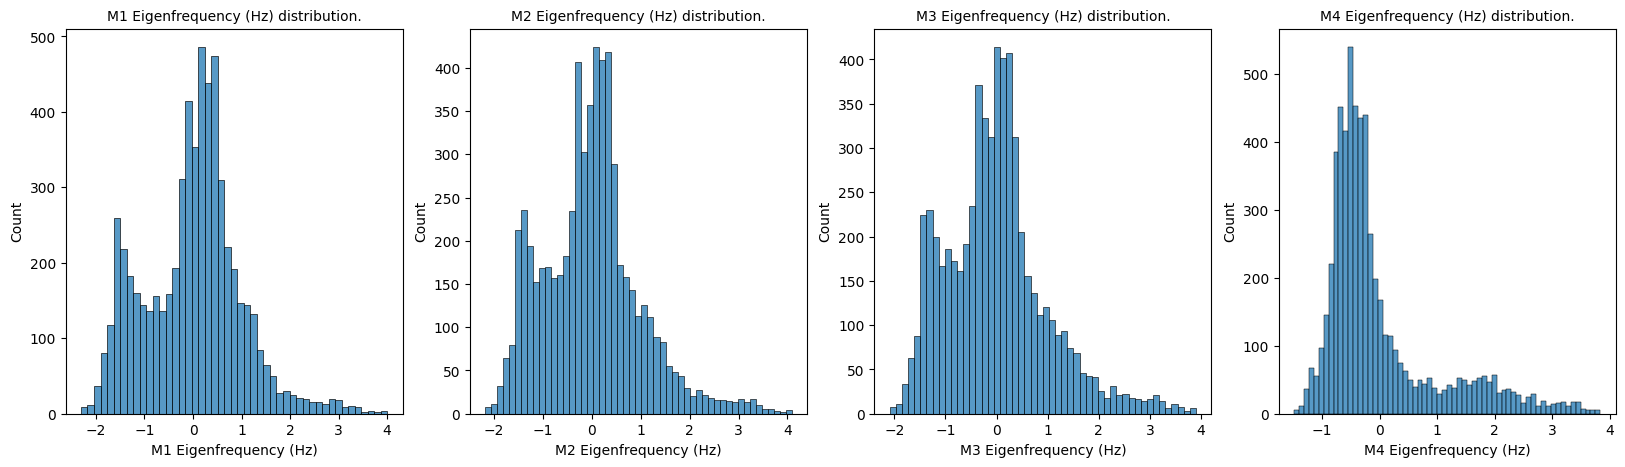

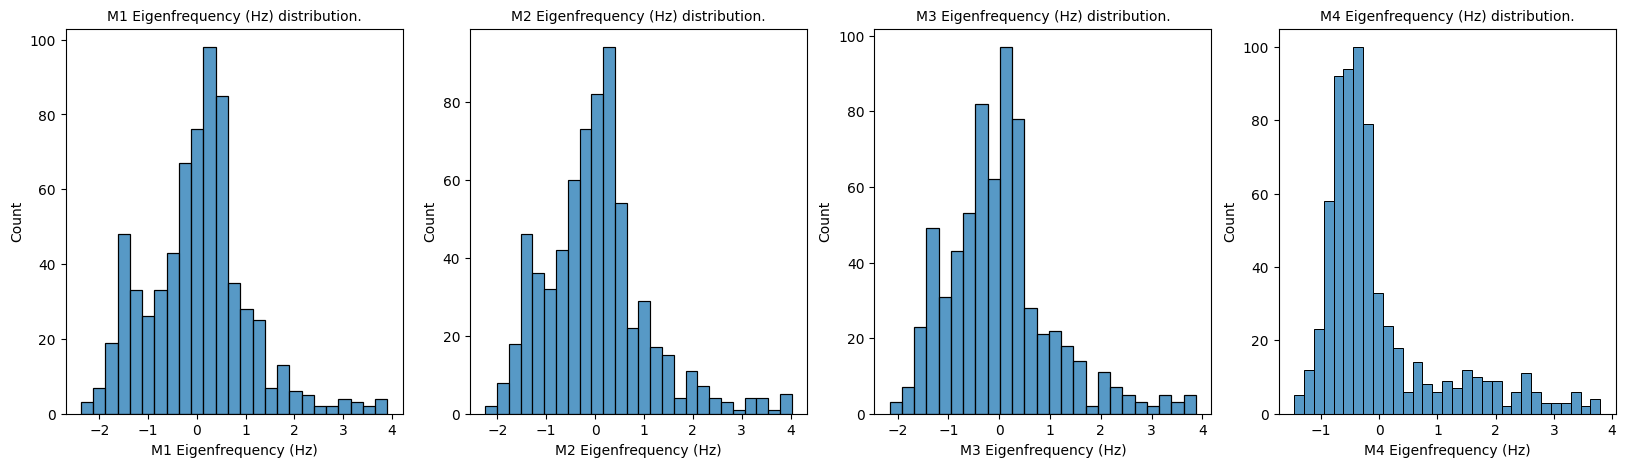

Fold N5;  MSE Loss: 0.121;  R2 Score: 0.367  


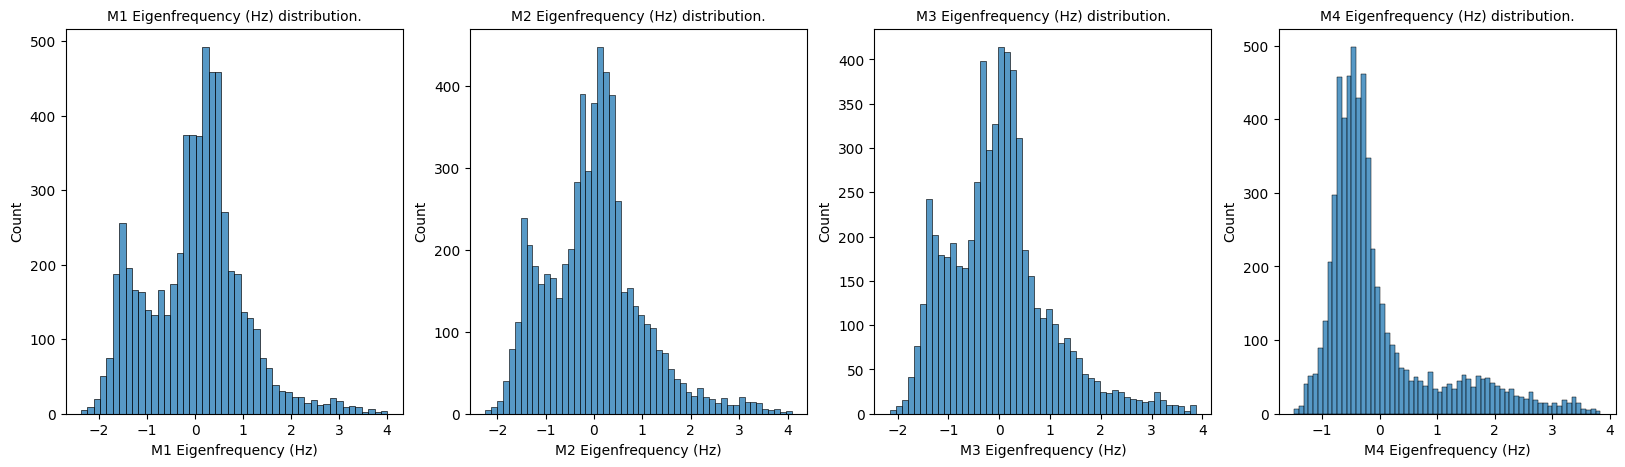

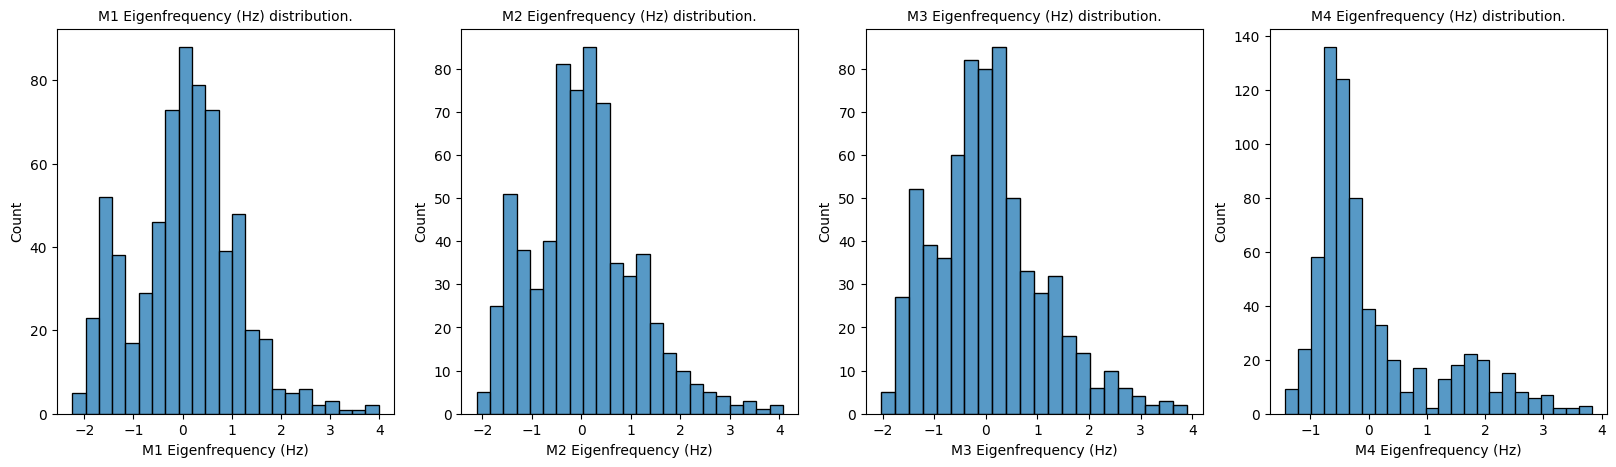

Fold N6;  MSE Loss: 0.130;  R2 Score: 0.698  


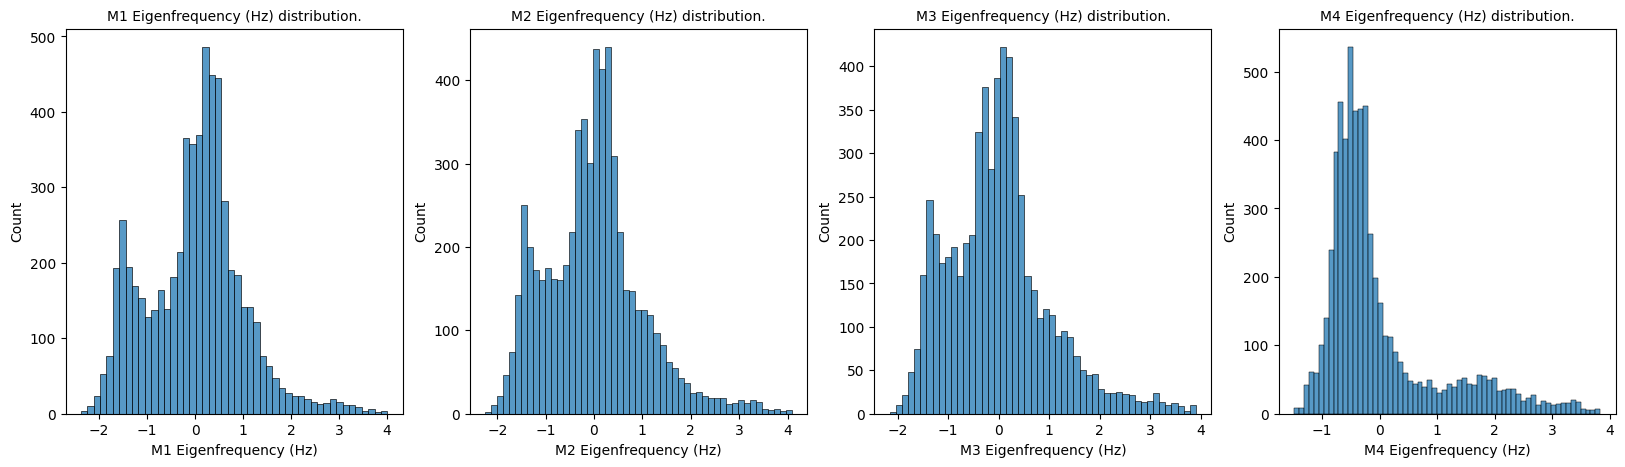

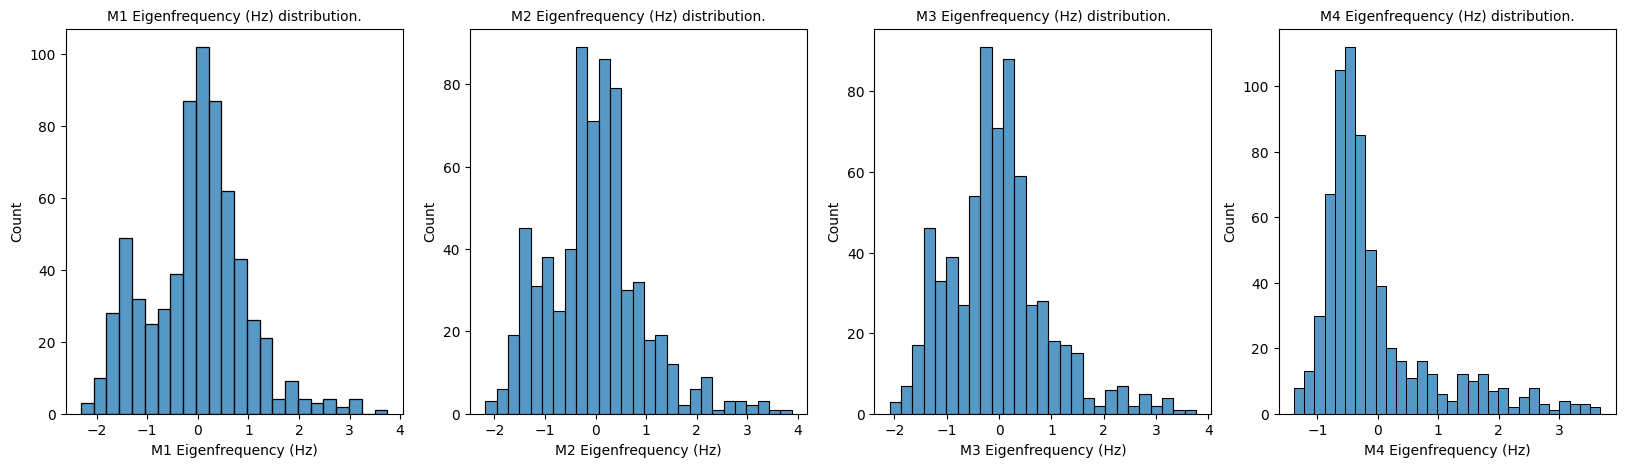

Fold N7;  MSE Loss: 0.113;  R2 Score: 0.117  


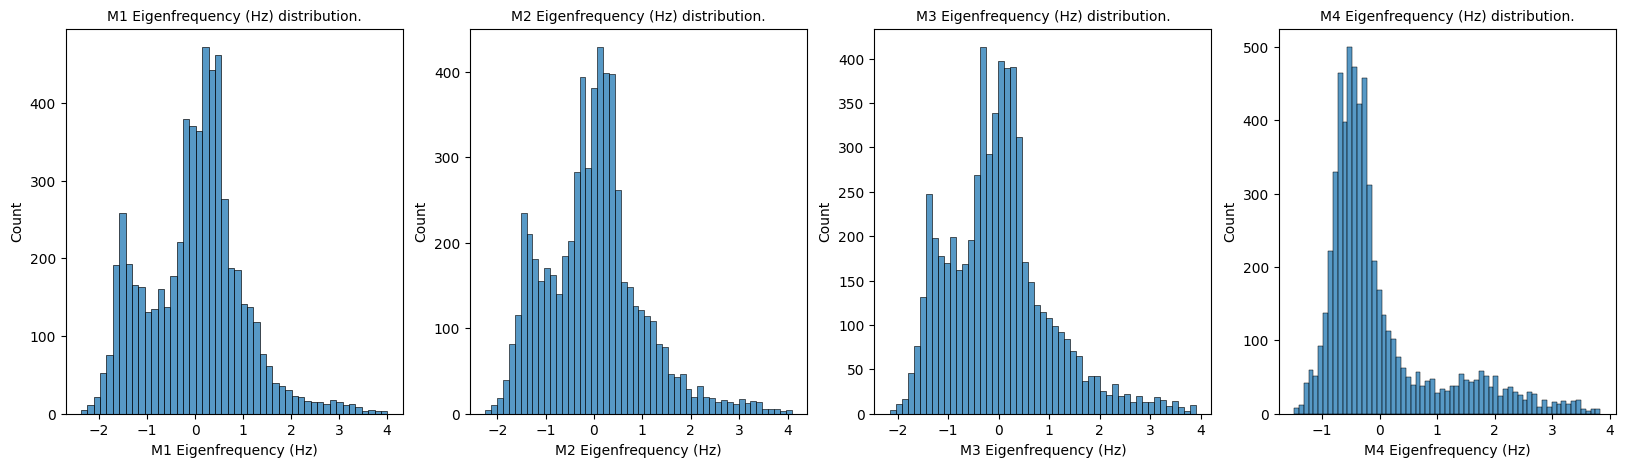

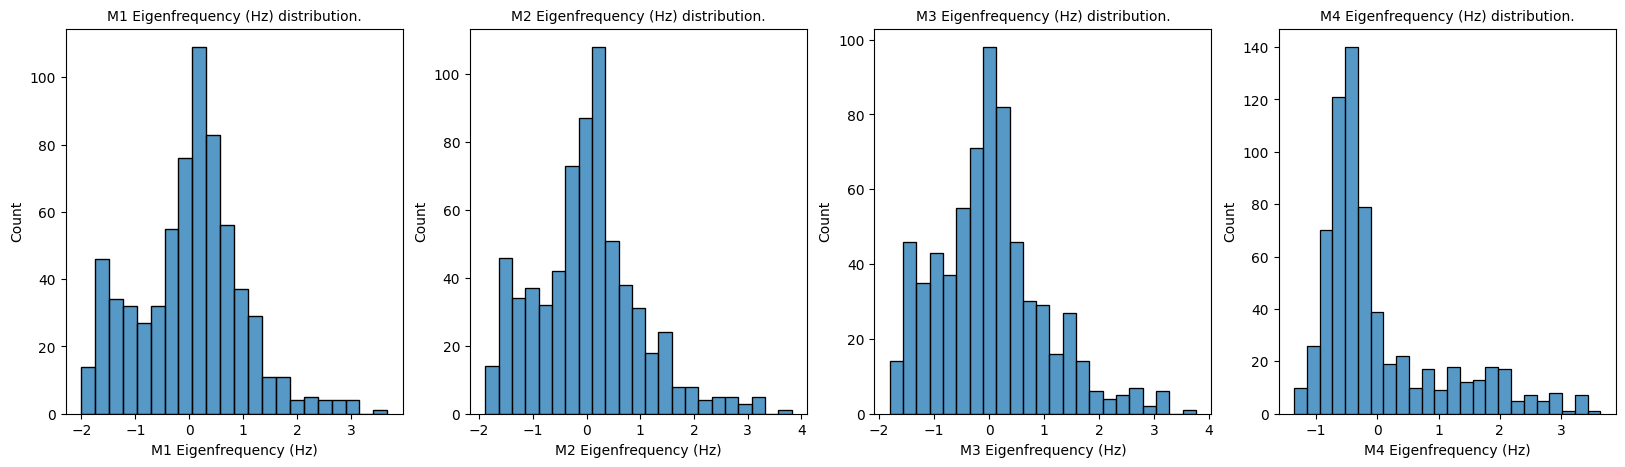

Fold N8;  MSE Loss: 0.538;  R2 Score: 0.766  


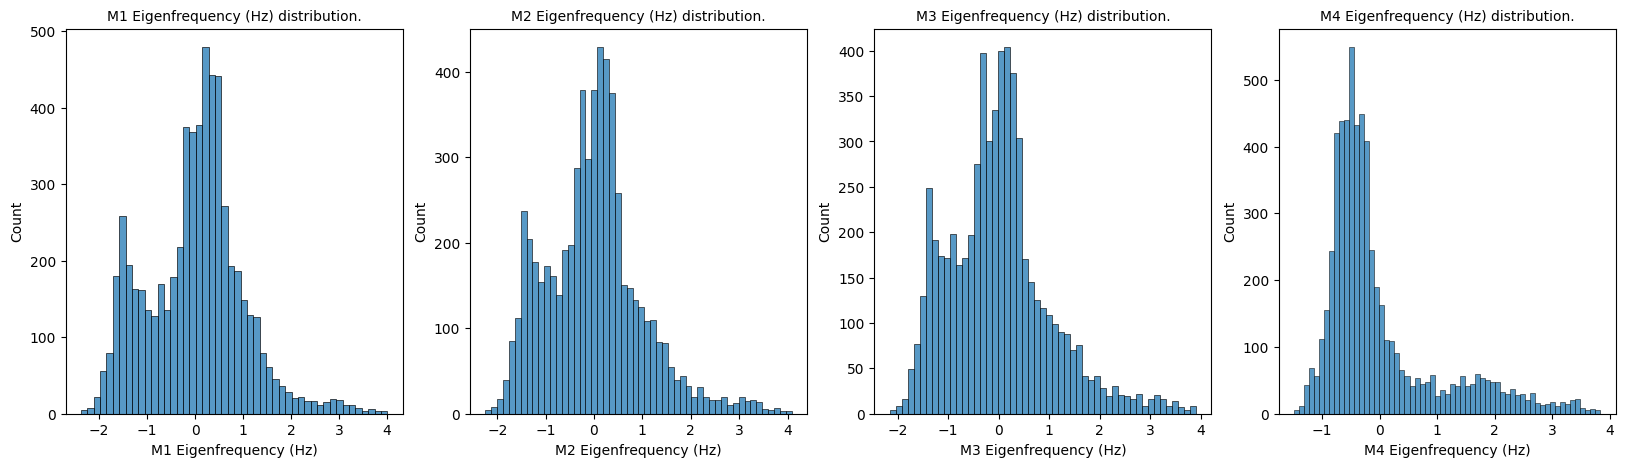

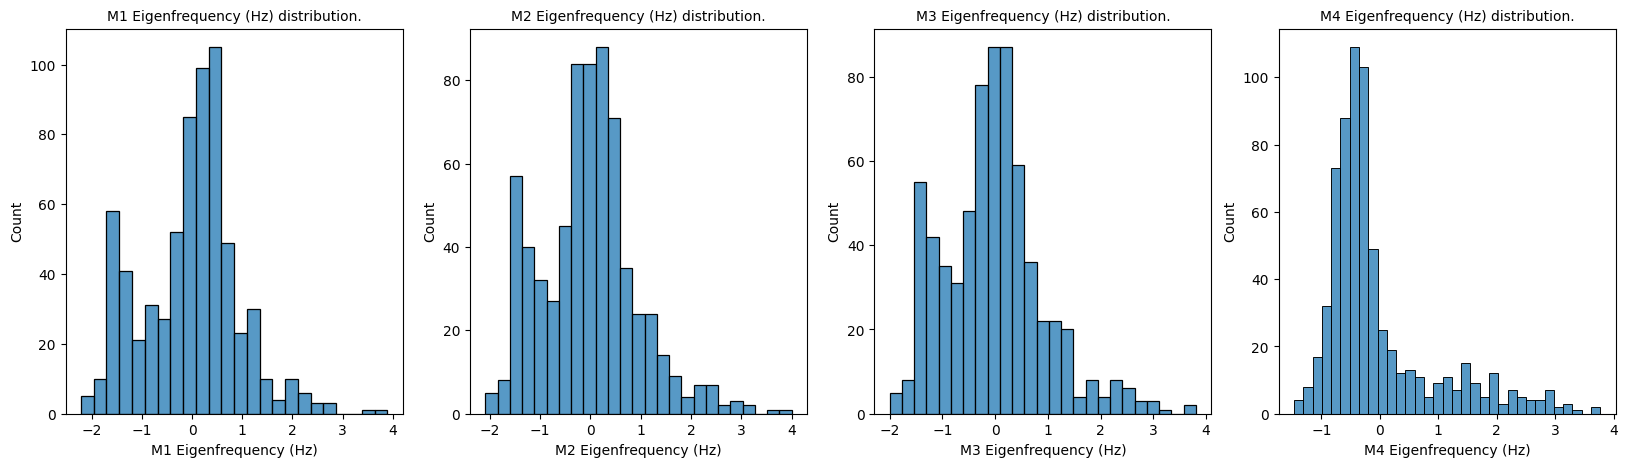

Fold N9;  MSE Loss: 0.216;  R2 Score: 0.817  


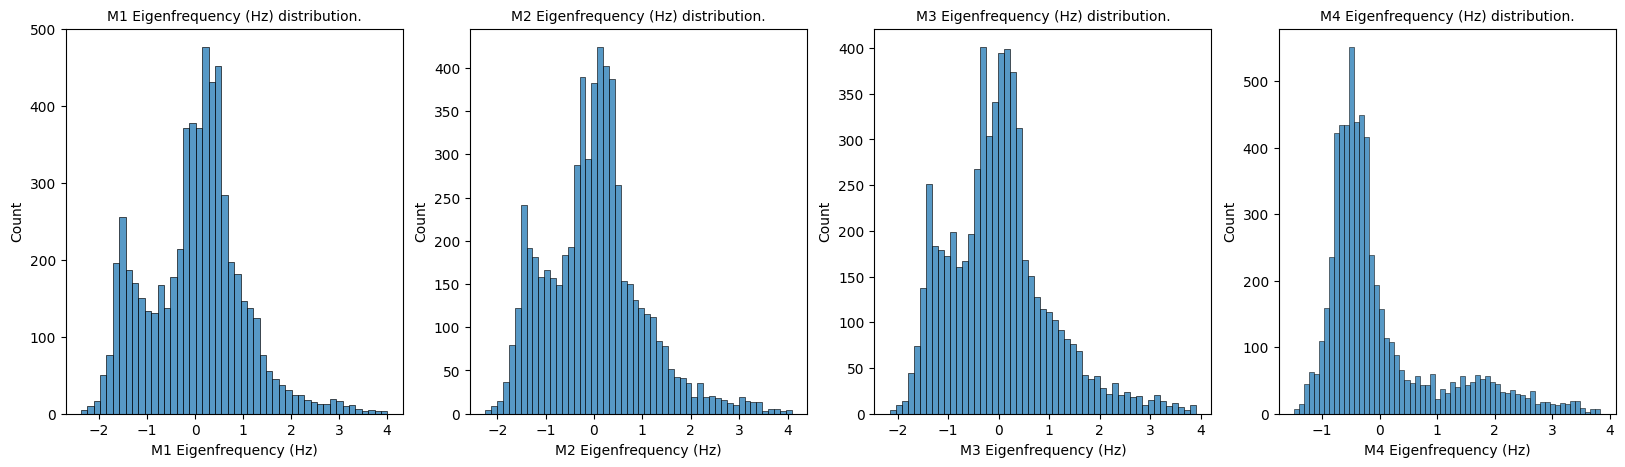

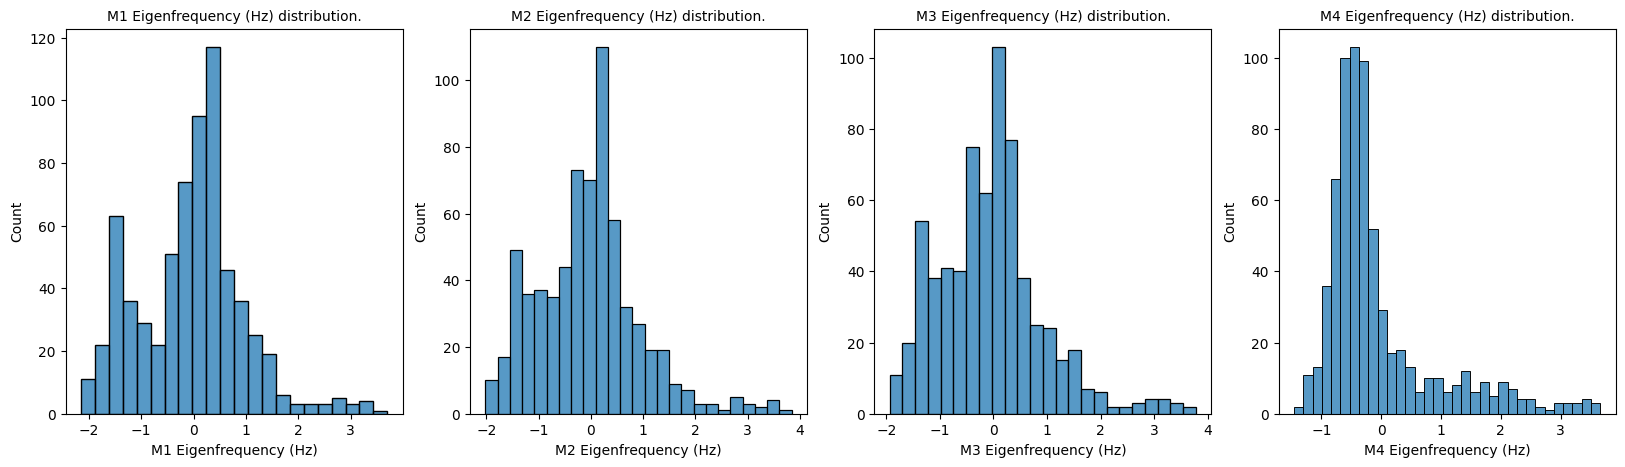

Fold N10;  MSE Loss: 0.155;  R2 Score: 0.840  


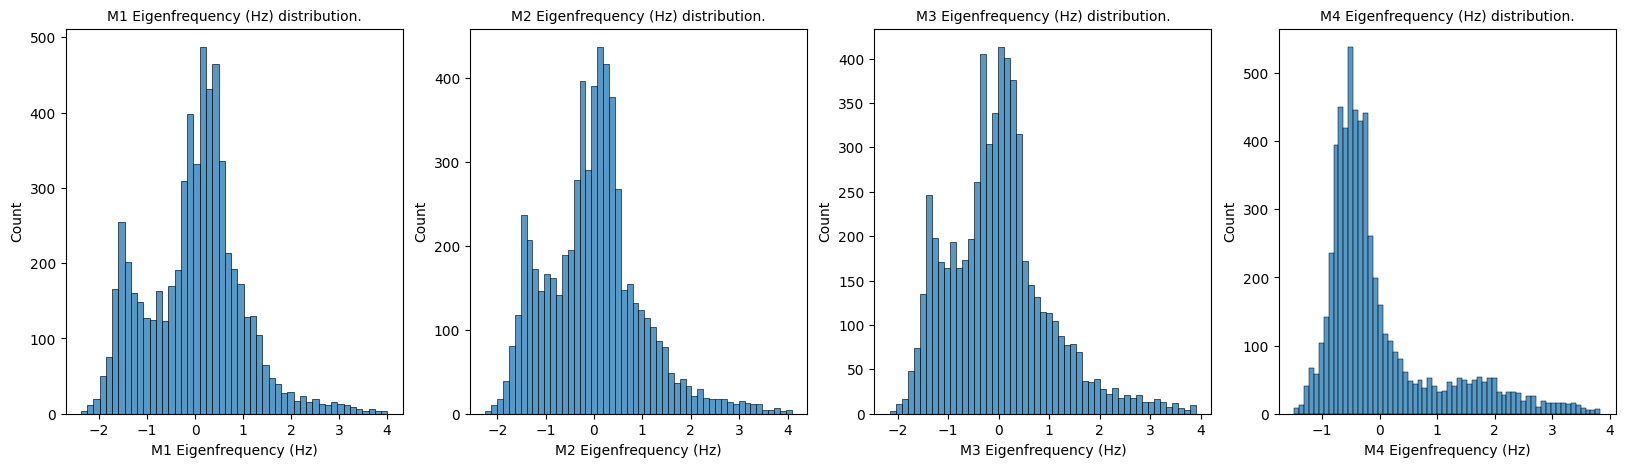

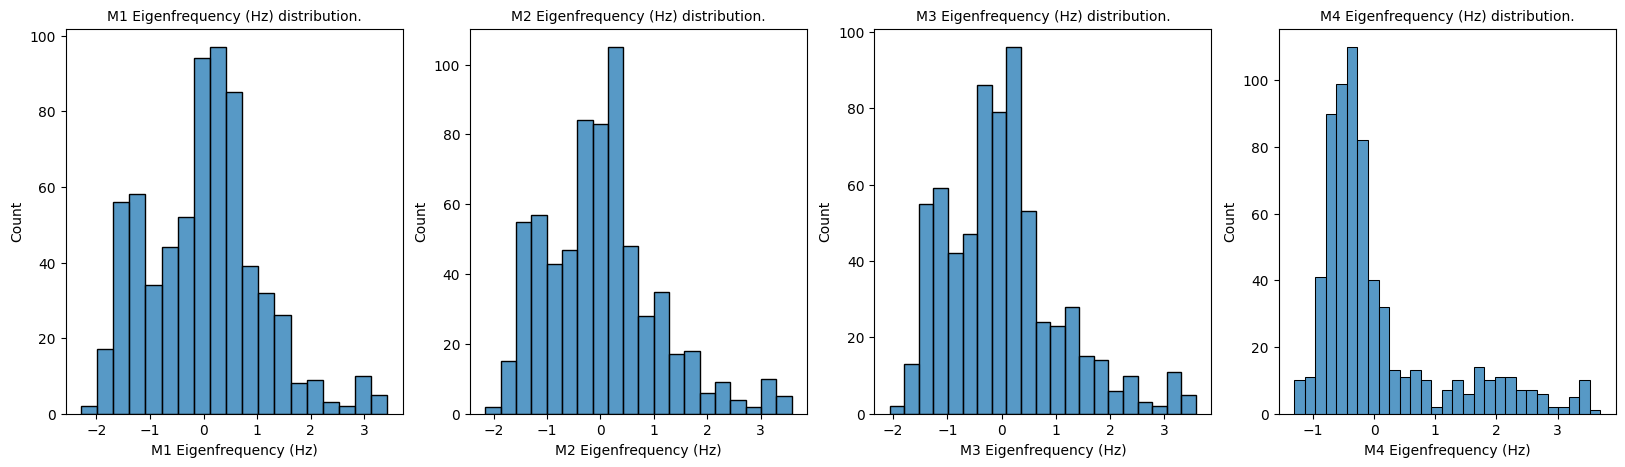

In [ ]:
count = 1
for train_indices, val_indices in kf.split(x_trainval.values):
    print(f'Fold N{count};  ' + f'MSE Loss: {abs(score_xgb["test_neg_mean_squared_error"][count - 1]):.3f};  ' + f'R2 Score: {score_xgb["test_r2"][count - 1]:.3f}  ')
    plot_distribution(y_trainval.iloc[train_indices.astype('int'), :], indices_to_plot=[0, 5, 10, 15], log_scale=False)
    plot_distribution(y_trainval.iloc[val_indices.astype('int'), :], indices_to_plot=[0, 5, 10, 15], log_scale=False)
    count += 1

Визуализация распределений

# Сравнение качества предсказаний разных моделей

In [ ]:
def compare_models(dict_list, model_names, param_names, modes, sharey, apply_log_mse, apply_log_r2):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25, 10), sharey=sharey)

    for row_index in range(0, 2):

        for col_index in range(0, 5):
            
            for model_index in range(0, len(model_names)):
                points_to_plot = []
                for mode in modes:
                    points_to_plot.append(dict_list[model_index][f'M{mode} {param_names[col_index]}'][row_index])

                ax[row_index, col_index].plot(modes, points_to_plot, label=model_names[model_index])

            # Дообработка графиков MSE
            if row_index == 0:
                if apply_log_mse:
                    ax[row_index, col_index].set_yscale('log')

                ax[row_index, col_index].set_ylabel('MSE Loss')
                ax[row_index, col_index].set_title(f"{param_names[col_index]} MSE Loss", fontsize=2 * 6)

            # Дообработка графиков R2
            if row_index == 1:
                if apply_log_r2:
                    ax[row_index, col_index].set_yscale('log')
                
                ax[row_index, col_index].set_ylabel('R2 Loss')
                ax[row_index, col_index].set_title(f"{param_names[col_index]} R2 Score", fontsize=2 * 6)

            ax[row_index, col_index].set_xlabel('Mode number')
            ax[row_index, col_index].tick_params(axis='y', labelleft=True)
            ax[row_index, col_index].set_xticks(modes)
            ax[row_index, col_index].grid(visible=True)
            ax[row_index, col_index].legend()
    plt.plot()

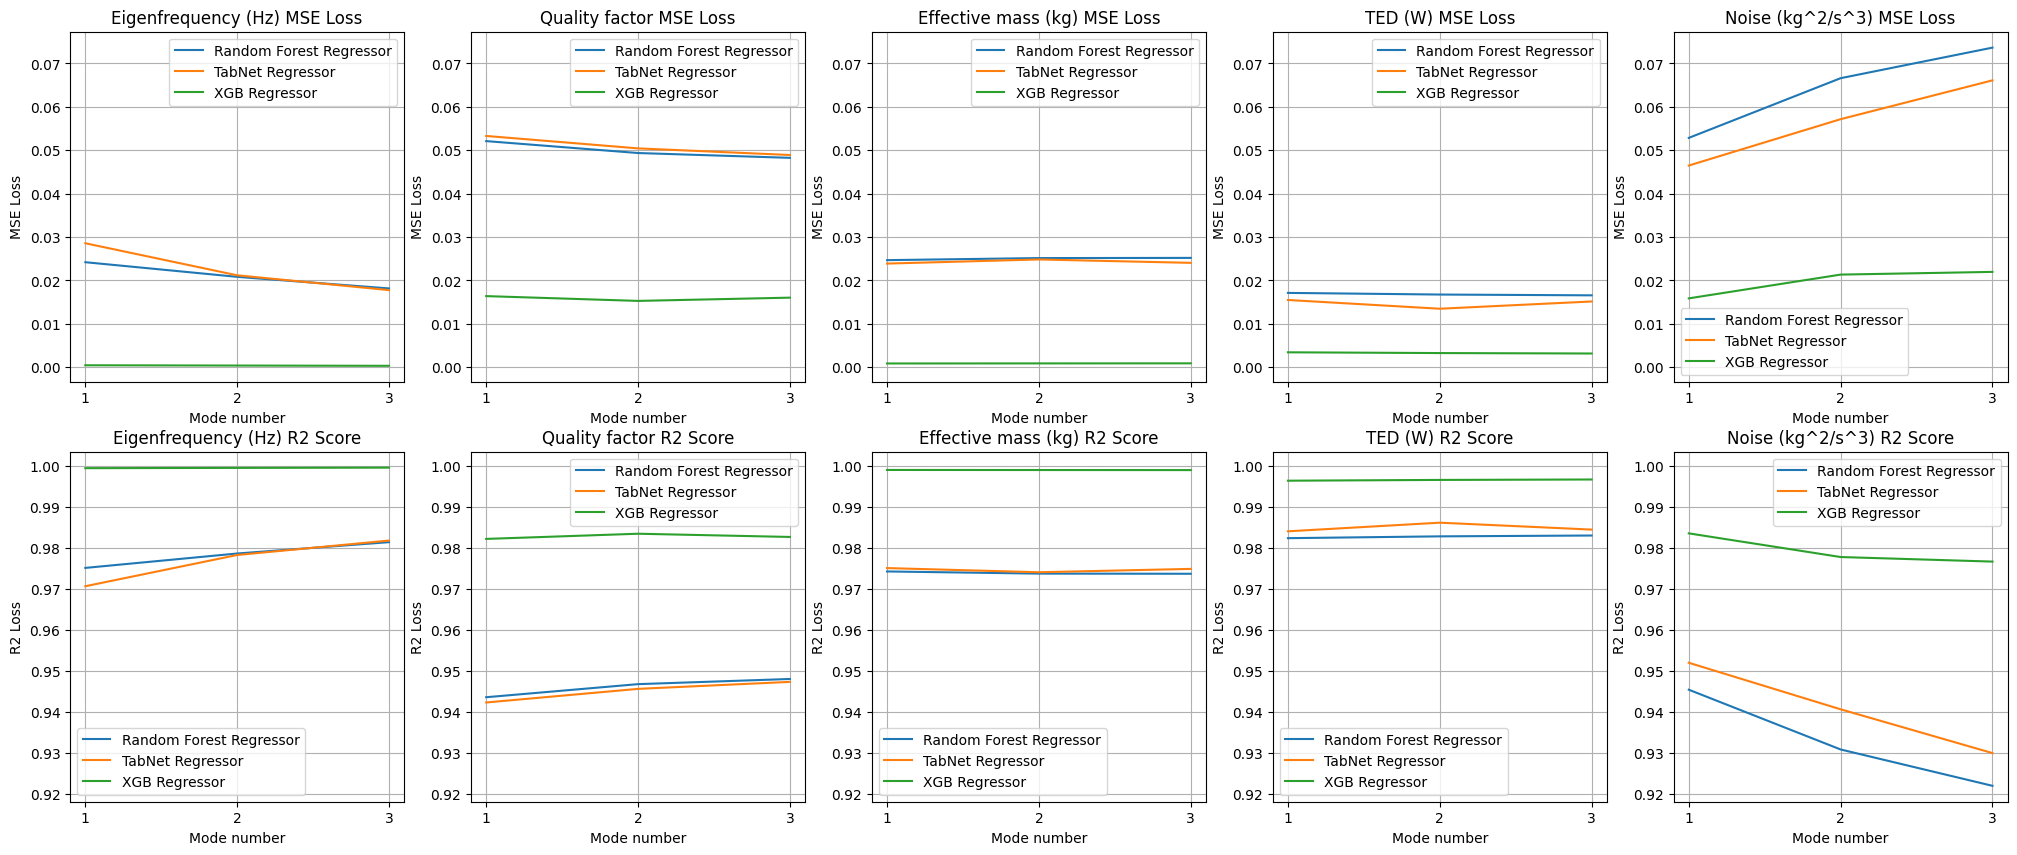

In [ ]:
modes = [1, 2, 3]
param_names = param_save
model_names = [#'Linear Regressor', 
               'Random Forest Regressor', 'TabNet Regressor', 'XGB Regressor']
dict_list = [#lin_metrics, 
             forest_metrics, tabnet_metrics, boost_metrics]

compare_models(dict_list=dict_list,
               model_names=model_names,
               param_names=param_names,
               modes=modes,
               sharey='row',
               apply_log_mse=False,
               apply_log_r2=False)

# Дополнительное тестирование

## Анализ реальных устройств

Пробуем дать модели на вход тестовые данные: либо параметры реально существующего устройства, либо параметры устройств, сгенерированных в FEM, но лежащие на границах распределений параметров.

In [ ]:
gate_U = 0
gate_D = 500
pretension = 0
pretension_lanc = 700e6

x_real = pd.DataFrame([[70, 200, 100, 30, 1, gate_D, gate_U, pretension],
                       [30, 170, 60, 80, 1, gate_D, gate_U, pretension],
                       [30, 300, 100, 30, 1, gate_D, gate_U, pretension_lanc],
                       [150, 300, 100, 30, 1, gate_D, gate_U, pretension_lanc]]) # это параметры реально изготовленного устройства
x_real.columns = x_train.columns

#x_real = x_test[x_test['Beam length (um)']>0]
#x_real = x_real[x_real['Beam length (um)']<0.04]

y_real_ = pd.DataFrame(np.ones(shape=(1, 20)))
y_real_.columns = y_train.columns
#y_real_.iloc[0, 0] = 2.166e6
#y_real_.iloc[1, 0] = 6.3e6
#y_real_.iloc[2, 0] = 11.6e6
#y_real_.iloc[3, 0] = 1.66e6

x_real = s.transform_real(x_real)

y_real_pred = model_boost.predict(x_real)

x_real, y_real_pred = s.reverse_transform(x_real, y_real_pred, concat_required=False)
y_real_pred = pd.DataFrame(y_real_pred)
y_real_pred.columns = y_train.columns

real_pred = pd.concat([x_real, y_real_pred], axis=1)
real_pred.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),Pretension (Pa),M1 Eigenfrequency (Hz),M1 Quality factor,...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 TED (W),M4 Noise (kg^2/s^3)
0,70.0,200.0,100.0,30.0,1.0,500.0,0.0,0.0,2146122.75,9.201338e+05,...,6460590.5,8.025117e+05,2.481620e-15,2.636560e-28,3.195035e-12,8734593.0,6.547612e+05,2.687013e-15,7.258446e-28,4.802286e-12
1,30.0,170.0,60.0,80.0,1.0,500.0,0.0,0.0,5387439.00,1.650536e+06,...,18261788.0,1.832343e+06,9.829508e-16,4.703224e-28,3.674796e-12,26375734.0,7.647293e+05,1.004574e-15,2.049408e-27,4.604700e-12
2,30.0,300.0,100.0,30.0,1.0,500.0,0.0,700000000.0,10167096.00,1.314652e+07,...,32401228.0,1.098469e+07,1.768462e-15,2.695523e-28,4.185478e-12,44480044.0,6.280968e+06,1.698850e-15,7.129105e-28,4.851679e-12
3,150.0,300.0,100.0,30.0,1.0,500.0,0.0,700000000.0,1906644.00,1.801480e+06,...,5764963.5,1.574158e+06,8.809109e-15,1.042747e-28,4.153242e-12,7638599.0,1.088966e+06,8.575605e-15,1.973576e-28,6.530410e-12


## Анализ специально сгенерированного датасета

Теперь дадим модели на вход специально сгенерированные параметры и посмотрим значения метрик качества. Сначала разделим спец-датасет на X- и Y-данные:

In [ ]:
filename = 'Data_Processed_Test.csv'
df_bound = pd.read_csv(filename)
df_bound = df_bound.drop(columns='Unnamed: 0')
df_bound.iloc[3:8].head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),...,M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 Noise (kg^2/s^3),M3 TED (W),M4 Eigenfrequency (Hz),M4 Quality factor,M4 Effective mass (kg),M4 Noise (kg^2/s^3),M4 TED (W)
3,70.0,286.842105,234.210526,33.947368,157.899474,531.052632,31.578995,1.560621e+06,16779.496146,7.023254e-15,...,5.561491e+06,15767.407884,6.708401e-15,3.859902e-24,1.096633e-11,8.664295e+06,15068.122275,7.799296e-15,6.990750e-24,1.547307e-11
4,200.0,310.526316,252.631579,36.842105,173.688421,583.157895,34.736884,4.519106e+05,18439.839348,2.585657e-14,...,1.386050e+06,18055.084240,2.599195e-14,4.637819e-25,9.126584e-12,1.884156e+06,17855.767357,2.597882e-14,6.302094e-25,1.412735e-11
5,550.0,334.210526,271.052632,39.736842,189.477368,635.263158,37.894774,1.469987e+05,19960.728691,8.501786e-14,...,4.426378e+05,19778.154843,8.503448e-14,6.493526e-26,4.660848e-12,5.921024e+05,19690.217524,8.510517e-14,8.692254e-26,7.587781e-12
6,900.0,357.894737,289.473684,42.631579,205.266316,687.368421,41.052663,8.205448e+04,21400.536859,1.603695e-13,...,2.466205e+05,21254.767807,1.603831e-13,2.577986e-26,3.832702e-12,3.293613e+05,21182.812980,1.603973e-13,3.443182e-26,6.273864e-12
7,1250.0,381.578947,307.894737,45.526316,221.055263,739.473684,44.210553,5.335479e+04,22829.223232,2.534520e-13,...,1.602761e+05,22696.272108,2.534668e-13,1.386426e-26,3.796320e-12,2.139495e+05,22630.562486,2.534842e-13,1.850867e-26,6.241699e-12


In [ ]:
param_general = ['Beam length (um)', 'Beam width (nm)', 'Thickness_1 (nm)', 'Thickness_2 (nm)', 'Temperature (K)', 'Distance (nm)', 'Gate voltage (V)']
param_save = ['Eigenfrequency (Hz)', 'Quality factor', 'Effective mass (kg)', 'TED (W)', 'Noise (kg^2/s^3)']

# Делим данные на Х и У
x_bound, y_bound = split_df(df_bound.iloc[3:8, 0:22], param_general=param_general, param_save=param_save, mode_number=mode_number)

x_bound, y_bound = s.transform(x_bound, y_bound)

In [ ]:
y_bound.head()

,M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),M1 TED (W),M1 Noise (kg^2/s^3),M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 TED (W),M2 Noise (kg^2/s^3),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3)
0,0.470468,-1.011035,-1.609442,-0.383637,3.510576,1.145602,-1.022917,-1.577005,-0.116727,3.777278,1.509468,-1.037913,-1.666033,-0.249017,3.835341
1,-2.203183,-0.909281,-0.097221,-0.868193,1.732490,-1.563608,-0.897655,-0.098042,-0.567337,1.949622,-1.297048,-0.881796,-0.098039,-0.383064,2.015283
2,-4.625953,-0.816074,1.283842,-1.337864,0.022445,-3.929308,-0.792564,1.277048,-1.051947,0.251174,-3.602727,-0.764210,1.274125,-0.873585,0.326606
3,-5.883742,-0.727836,2.020170,-1.470653,-0.789060,-5.151434,-0.698002,2.012157,-1.188642,-0.551270,-4.784189,-0.663443,2.008684,-1.016383,-0.466871
4,-6.812284,-0.640279,2.551218,-1.483091,-1.334641,-6.052988,-0.604953,2.542464,-1.198032,-1.090405,-5.654686,-0.565072,2.538517,-1.023345,-0.999648


Смотрим качество целевых метрик:

In [ ]:
y_pred_bound = model_boost.predict(x_bound)
print("MSE на тестовом наборе: {:.3f}".format(mean_squared_error(y_bound, y_pred_bound)))
print("R2 на тестовом наборе: {:.3f}".format(r2_score(y_bound, y_pred_bound)))

MSE на тестовом наборе: 0.777
R2 на тестовом наборе: 0.776


In [ ]:
df_pred = s.reverse_transform(x_test=x_bound, y_pred=y_pred_bound, concat_required=True)
df_pred.head()

,Beam length (um),Beam width (nm),Thickness_1 (nm),Thickness_2 (nm),Temperature (K),Distance (nm),Gate voltage (V),M1 Eigenfrequency (Hz),M1 Quality factor,M1 Effective mass (kg),...,M2 Eigenfrequency (Hz),M2 Quality factor,M2 Effective mass (kg),M2 TED (W),M2 Noise (kg^2/s^3),M3 Eigenfrequency (Hz),M3 Quality factor,M3 Effective mass (kg),M3 TED (W),M3 Noise (kg^2/s^3)
0,70.0,286.842105,234.210526,33.947368,157.899474,531.052632,31.578995,2.131680e+06,16472.193359,1.033222e-14,...,3.137880e+06,16356.763672,1.047091e-14,6.381855e-12,9.326751e-25,4.272870e+06,16102.403320,1.021296e-14,9.496110e-12,1.209823e-24
1,200.0,310.526316,252.631579,36.842105,173.688421,583.157895,34.736884,9.677731e+05,18031.966797,2.021149e-14,...,1.515939e+06,17810.384766,1.989069e-14,6.349188e-12,3.703002e-25,1.966142e+06,17380.689453,2.003698e-14,1.011649e-11,4.951910e-25
2,550.0,334.210526,271.052632,39.736842,189.477368,635.263158,37.894774,4.134361e+05,19648.279297,6.481180e-14,...,6.358578e+05,19481.917969,6.675267e-14,3.286006e-12,3.968228e-26,8.248775e+05,18895.609375,6.289076e-14,4.896869e-12,5.143152e-26
3,900.0,357.894737,289.473684,42.631579,205.266316,687.368421,41.052663,2.576767e+05,20944.332031,1.129303e-13,...,3.900662e+05,21117.375000,1.111584e-13,2.497013e-12,1.629811e-26,5.152059e+05,20254.921875,1.116197e-13,4.096162e-12,2.095636e-26
4,1250.0,381.578947,307.894737,45.526316,221.055263,739.473684,44.210553,2.586921e+05,22785.912109,1.254652e-13,...,3.922604e+05,22942.560547,1.299965e-13,2.755297e-12,1.511158e-26,5.183424e+05,22197.222656,1.282868e-13,4.557020e-12,1.964383e-26
